# pomegranate: fast and flexible probabilistic modelling

Presenter: Jacob Schreiber <br>
Date: 8/16/2016 

In [1]:
%pylab inline
import seaborn, pandas, itertools, time, random
seaborn.set_style('whitegrid')
from pomegranate import *
numpy.set_printoptions(suppress=True)

random.seed(0)
numpy.random.seed(0)

import matplotlib
matplotlib.rcParams['xtick.labelsize'] = 14
matplotlib.rcParams['ytick.labelsize'] = 14
matplotlib.rcParams['axes.labelsize'] = 16
matplotlib.rcParams['axes.titlesize'] = 16
matplotlib.rcParams['figure.figsize'] = (10, 6)
matplotlib.rcParams['legend.fontsize'] = 16

Populating the interactive namespace from numpy and matplotlib


pomegranate is a probabilistic modelling library which focuses on combining an ease of use with a speedy cython backend. Its precursor, yahmm, began while I was an undergraduate working in the nanopore group at UC Santa Cruz which was developing a new DNA sequencing tool. Since it was in its beginning stages, sequence analysis using this tool was primarily done by hand, which was extremely slow and could suffer significantly from human bias. Through the use of hidden Markov models implemented in yahmm this process was automated, speeding up the analysis by several orders of magnitude while removing human bias and cutting out around 80% of the error (increasing accuracy from ~90% to ~98%).

pomegranate began when I was in graduate school at the University of Washington and taking machine learning courses. Homework assignments frequently required the implementation of a model, and I noticed that many implementations simply involved rearranging the components of yahmm into other useful models, such as Naive Bayes, mixture models, and Bayesian networks. Thus, pomegranate was born.

While efficient, pomegranate didn't fully utilize the benefits that cython can provide until last summer, while I was doing a summer internship working on sklearn. During the internship I was working on speeding up decision tree regressors, and a mathematical trick I proposed was able to speed them up up to 4x faster in some cases. This taught my how to write bare-bones and parallelizable cython code and utilize computational tricks to speed up seemingly-complex code. I've taken this knowledge to significantly improve the internals of pomegranate and make it extremely fast.

The main models which pomegranate implements and I will be discussing in this talk are

1. Probability Distributions
2. Naive Bayes
3. Markov Chains 
4. General Mixture Models
5. Hidden Markov Models
6. Bayesian Networks

One of the core tenets of pomegranate is that every model is really a probability distribution. We're all familiar with simple distributions such as normal or uniform distributions, but even a Bayesian network can be thought of as a distribution which is factored along a graph. This idea makes pomegranate extremely flexible, allowing for models to be stacked within each other to neatly produce hidden Markov models with general mixture model emissions, Naive Bayes classifiers with Bayesian network emissions, and mixtures of hidden Markov models.

Here is a table of the ways in which models can be stacked. On the left is a chart of what is possible, with dark blue indicating that models can be stacked in a certain way, and light blue indicating a way models can be stacked which will be added in the near future. On the right is a chart of the comparison of pomegranates models to other known packages, with light red indicating model stacking which is known to exist in other packages but pomegranate provides more support for. For example, sklearn implements mixture models, but these are limited to Gaussian emissions, while pomegranate supports mixture models of arbitrary distributions. Dark red indicates new model stacking that no other known package supports, such as mixtures of hidden Markov models. If you know of a package which supports these meshes I'd love to know!

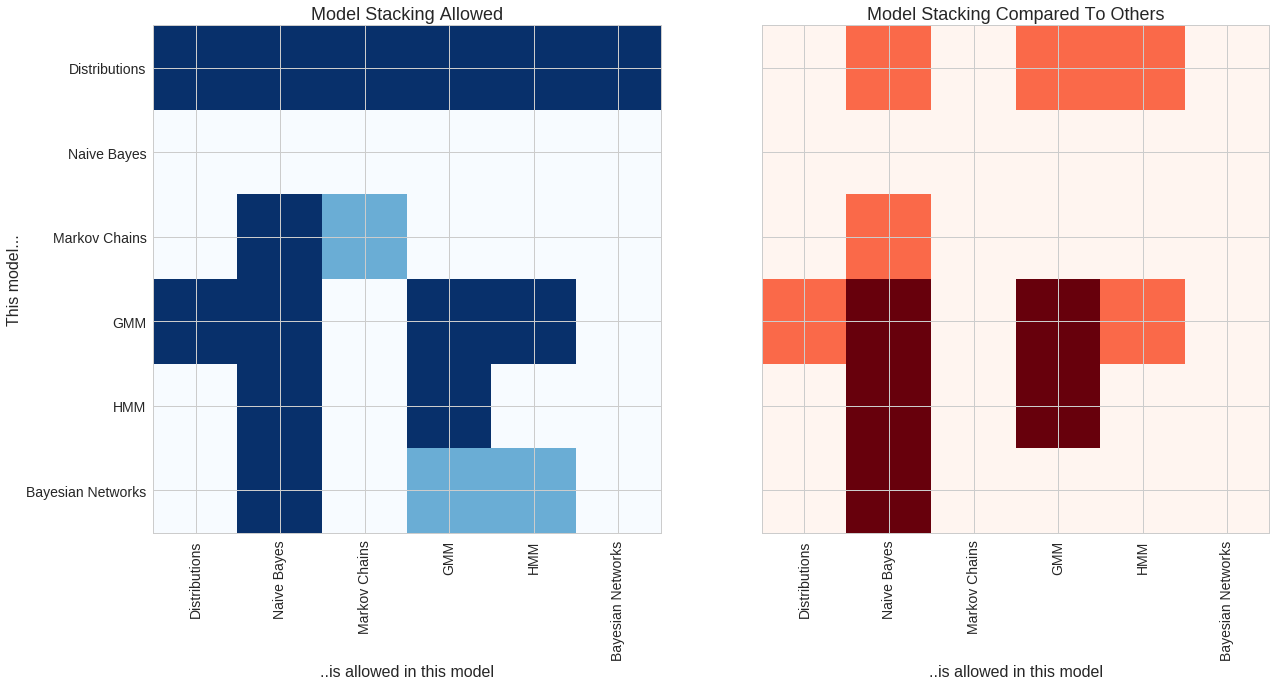

In [2]:
labels = 'Distributions', 'Naive Bayes', 'Markov Chains', 'GMM', 'HMM', 'Bayesian Networks' 
X = [[1.0, 1.0, 1.0, 1.0, 1.0, 1.0],
     [0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
     [0.0, 1.0, 0.5, 0.0, 0.0, 0.0],
     [1.0, 1.0, 0.0, 1.0, 1.0, 0.0],
     [0.0, 1.0, 0.0, 1.0, 0.0, 0.0],
     [0.0, 1.0, 0.0, 0.5, 0.5, 0.0]]

Y = [[0.0, 0.5, 0.0, 0.5, 0.5, 0.0],
     [0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
     [0.0, 0.5, 0.0, 0.0, 0.0, 0.0],
     [0.5, 1.0, 0.0, 1.0, 0.5, 0.0],
     [0.0, 1.0, 0.0, 1.0, 0.0, 0.0],
     [0.0, 1.0, 0.0, 0.0, 0.0, 0.0]]

plt.figure(figsize=(20, 10))
plt.subplot(121)
plt.title("Model Stacking Allowed", fontsize=18)
plt.imshow(X, interpolation='nearest', cmap='Blues')
plt.xticks(range(6), labels, rotation=90)
plt.xlabel("..is allowed in this model")
plt.ylabel("This model...")
plt.yticks(range(6), labels)

plt.subplot(122)
plt.title("Model Stacking Compared To Others", fontsize=18)
plt.imshow(Y, interpolation='nearest', cmap='Reds')
plt.xticks(range(6), labels, rotation=90)
plt.xlabel("..is allowed in this model")
plt.yticks(range(6), '')
plt.show()

All of the models (and stacks of models) in pomegranate support the same core functionality and methods. You can reach about the API more at <a href="pomegranate.readthedocs.io/en/latest">the readthedocs site</a>. These methods are almost all implemented with a cython backend which releases the GIL. This makes the operations especially fast, but it also makes them all parallelizable using ~multithreading~. In many cases, this can be much more efficient than multiprocessing.

To utilize this parallelization, pomegranate has implemented some parallelization wrappers, which can run model prediction, log probability calculations, or model fitting in parallel for any model or stack of models. I will end this tutorial by showing an example from my undergraduate research working on the nanopore DNA sequencing device--fitting a mixture of hidden Markov models efficiently using 40 threads on several hundred long sequences.

# Models

Since all models share the same core set of functionality, let's start with a quick API reference. All models have the following methods:

1. probability
2. log_probability
3. fit
4. sample
5. summarize
6. from_summaries
7. clear_summaries
8. to_json
9. from_json

The first three methods are likely the most used functions---updating parameters of the distribution, and evaluating samples using the model parameters. 

Methods 5-7 implement pomegranate's out-of-core learning scheme. All models can summarize data down to its sufficient statistics using 'summarize', update model parameters exactly using these sufficent statistics using 'from_summaries', and then clear the stored sufficent statistics using 'clear_sumaries'. This will ultimately allow you to decide if you want to clear the summaries after each parameter updates, or continue with online learning to get better estimates of a single process.

In addition, for models composed of simple distributions, a sklearn-like API is exposed for the common operations:

1. predict
2. predict_proba
3. predict_log_proba

The 'predict' method returns the index of the model which most likely generated the sample, 'predict_proba' returns the posterior probabilities of each model having generated the sample, and 'predict_log_proba' returns the log probabilities.


## 1. Probability Distributions

The basic unit of probabilistic modelling is the probability distribution. Most people are familiar with simple ones like the Normal distribution, but pomegranate supports a wide variety of them. Here is a full list of the probability distributions which pomegranate currently (8/12/2016) supports.

Univariate Distributions
1. UniformDistribution
2. NormalDistribution
3. LogNormalDistribution
4. ExponentialDistribution
5. BetaDistribution
6. GammaDistribution
7. DiscreteDistribution
8. PoissonDistribution

Kernel Densities
1. GaussianKernelDensity
2. UniformKernelDensity
3. TriangleKernelDensity

Multivariate Distributions
1. IndependentComponentsDistribution
2. MultivariateGaussianDistribution
3. DirichletDistribution
4. ConditionalProbabilityTable
5. JointProbabilityTable

The first two methods are likely the most used functions---updating parameters of the distribution, and evaluating samples using the model parameters. The next three are involved with the out-of-core learning API, where `summarize` will store sufficient statistics from a dataset, `from_summaries` will update the model parameters using the stored sufficient statistics, and `clear_summaries` will reset the sufficient statistics if you don't want past points to influence the update anymore. Lastly, `to/from_json` allow you to serialize your models.

Let's take a look at one of the simpler distributions, the Normal Distribution. We can specify it easily in terms of the mean $\mu$ and the standard deviation $\sigma$.

In [3]:
a = NormalDistribution(0, 2)
b = NormalDistribution(1, 0.5)

We can look at the log probability of some points under these distributions using the `log_probability` method.

In [4]:
print a.log_probability(5)
print b.log_probability(5)

-4.73708571376
-32.2257913526


We can fit any type of distribution to the data using the class method `Model.from_sample(X)`. This uses maximum likelihood estimates on the data to derive parameters for the distribution. In the case of the normal distribution, it just calculates the mean and standard deviation of the data.

Let's fit a normal distribution to that data and take a look at it

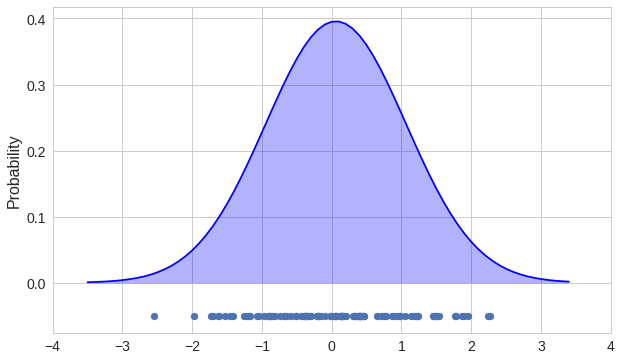

In [5]:
data = numpy.random.randn(100)

a = NormalDistribution.from_samples(data)

x = numpy.arange(-3.5, 3.5, 0.1)
y = map( a.probability, x )

plt.plot(x, y, c='b')
plt.fill_between(x, 0, y, color='b', alpha=0.3)
plt.scatter(data, numpy.zeros(100)-0.05)
plt.ylabel('Probability')
plt.xlim(-4, 4)
plt.show()

In addition to the basic fit method, pomegranate also supports out-of-core learning to train on datasets which don't fit in memory through the `summarize` and `from_summaries` methods. Essentially, the `summarize` method will reduce a batch of data down to its sufficient statistics, and the `from_summaries` method will calculate an exact update to the model parameters based on the stored sufficient statistics. A simple example of this is the Normal Distribution, where the three sufficient statistics are $\sum\limits_{i=1}^{n}w_{i}$, $\sum\limits_{i=1}^{n}w_{i}x_{i}$, and $\sum\limits_{i=1}^{n} w_{i}x_{i}^{2}$. Since this sum can be broken into parts, you can run `summarize` as many times as necessary to analyze the entire dataset. Once you're done summarizing data, you can then run `from_summaries`, which calculates the following:

\begin{align}
\mu &= \frac{\sum\limits_{i=1}^{n}w_{i}x_{i}}{\sum\limits_{i=1}^{n}w_{i}} \\
\sigma^{2} &= \frac{\sum\limits_{i=1}^{n} w_{i}x_{i}^{2}}{\sum\limits_{i=1}^{n} w_{i}} - \frac{\left(\sum\limits_{i=1}^{n} w_{i}x_{i} \right)^{2}}{\left( \sum\limits_{i=1}^{n} w_{i} \right)^{2}}
\end{align}

Let's confirm that this is true by taking a look at two distributions, one fit to the entire thing, and one summarized over five chunks of data.

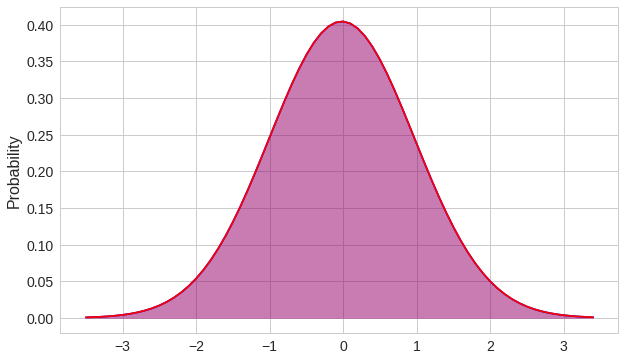

Fit Mean:       -0.0174820965846, Fit STD:       0.986767322871
Summarize Mean: -0.0174820965846, Summarize STD: 0.986767322871


In [6]:
data = numpy.random.randn(5000)
a = NormalDistribution(5, 2)
b = NormalDistribution(5, 2)

a.fit(data)
b.summarize(data[:1000])
b.summarize(data[1000:2000])
b.summarize(data[2000:3000])
b.summarize(data[3000:4000])
b.summarize(data[4000:])
b.from_summaries()


x = numpy.arange(-3.5, 3.5, 0.1)
ya = map( a.probability, x )
yb = map( b.probability, x )

plt.plot(x, ya, c='b')
plt.plot(x, yb, c='r')
plt.fill_between(x, 0, ya, color='b', alpha=0.3)
plt.fill_between(x, 0, yb, color='r', alpha=0.3)
plt.ylabel('Probability')
plt.show()

print "Fit Mean:       {}, Fit STD:       {}".format( *a.parameters )
print "Summarize Mean: {}, Summarize STD: {}".format( *b.parameters )

## Speed

Let's compare the speed against numpy for extracting model parameters and scipy for calculating the log probability of a point under these parameters.

In [7]:
data = numpy.random.randn(1000)

print "numpy time:"
%timeit -n 100 data.mean(), data.std()
print
print "pomegranate time:"
%timeit -n 100 NormalDistribution.from_samples(data)

numpy time:
100 loops, best of 3: 46.7 µs per loop

pomegranate time:
100 loops, best of 3: 23.2 µs per loop


Looks like we're around twice as fast at extracting the mean and standard deviation. This is mostly because the mean and variances are calculated together in pomegranate through the use of the sufficient statistics, instead of going through the entire array twice to calculate the mean and then the standard deviation.

In [8]:
from scipy.stats import norm

d = NormalDistribution(0, 1)

print "scipy time:"
%timeit -n 100 norm.logpdf(2, 0, 1)
print
print "pomegranate time:"
%timeit -n 100 NormalDistribution(0, 1).log_probability(2)
print
print "pomegranate with (w/ created object)"
%timeit -n 100 d.log_probability(2)
print
print "logp difference: {}".format( norm.logpdf(2, 0, 1) - NormalDistribution(0, 1).log_probability( 2 ) )

scipy time:
100 loops, best of 3: 112 µs per loop

pomegranate time:
100 loops, best of 3: 560 ns per loop

pomegranate with (w/ created object)
100 loops, best of 3: 122 ns per loop

logp difference: -3.99236199655e-13


One of the reasons which pomegranate can be so fast at calculating log probabilities is that it is able to cache parts of the logpdf equation so that it doesn't need to do all of the calculations each time. For example, let's look at the Normal distribution pdf equation:

\begin{equation}
P(X|\mu, \sigma) = \frac{1}{\sqrt{2\pi}\sigma} exp \left( -\frac{(x - \mu)^{2}}{2\sigma^{2}} \right) \\
\end{equation}

We can take the log of this to simplify it.

\begin{equation}
logP(X|\mu, \sigma) = -\log \left(\sqrt{2\pi}\sigma \right) - \frac{(x-\mu)^{2}}{2\sigma^{2}}
\end{equation}

pomegranate speeds up this calculation by caching $-\log(\sqrt{2\pi}\sigma)$ and $2\sigma^{2}$ when the object is created. This means that the equation is simplified to the following:

\begin{equation}
logP(X|\mu, \sigma) = \alpha - \frac{(x - \mu)^{2}}{\beta}
\end{equation}

We don't need to calculate any logs or exponentials here, just a difference, a multiplication, a division, and a subtraction.

It is worth noting that numpy and scipy supports vectorized operations across an array of samples at the same time. As the size of this array grows, it may become faster to use numpy or scipy than to use pomegranate. However, most of the models inside pomegranate only require the calculation of one value at a time. Because of this, it's more useful for pomegranate to have fast one-sample calculations than vectorized ones.

## Example: Gossip Girl

Let's turn now to a practical and useful example of how probabilistic modelling can help us.

A few years ago, my girlfriend wanted me to watch <i>Gossip Girl</i> with her. The show follows a group of angsty teenagers in Manhattan who take turns being in relationships with each other while constantly disappointing their parents. In the backdrop, an enigmatic figure known as 'gossip girl' sends out text message 'blasts' to stir up trouble--usually just in time to cause needless drama which could be solved if the characters ever decided to talk to each other. A mystery of the show is 'Who is Gossip Girl', with the implication that one of the main characters is secretly gossip girl.

Let's take a look at some of the blasts.

In [9]:
data = pandas.read_excel('GGBlasts.xlsx')
blasts = data['Blast']

print blasts[1]
print
print blasts[5]

Spotted: Lonely Boy. Can't believe the love of his life has returned. If only she knew who he was. But everyone knows Serena. And everyone is talking. Wonder what Blair Waldorf thinks. Sure, they're BFF's, but we always thought Blair's boyfriend Nate had a thing for Serena. 

Why'd she leave? Why'd she return? Send me all the deets. And who am I? That's the secret I'll never tell. The only one. —XOXO. Gossip Girl. 


I took that last blast as a challenge. I wanted to figure out which of the characters was gossip girl, and I wanted to use data science in order to do it.

To do this, the blasts were first all encoded as being either in favor of someone's agenda, or against someone's agenda. Presumably, the character who the blasts help the most would be gossip girl. So let's now take a look at a bar chart of the number of positive blasts minus the number of negative blasts. 

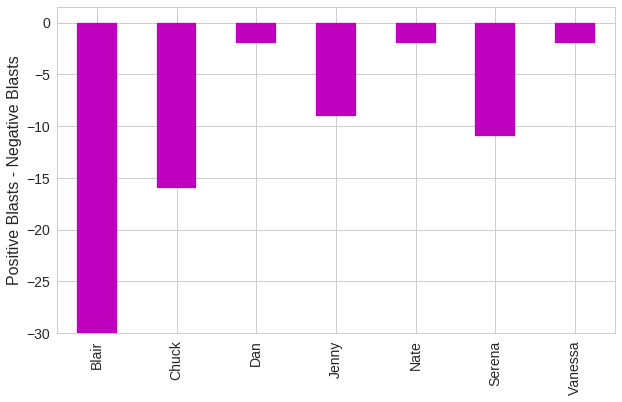

In [10]:
data = data.fillna(0)
data.sum(axis=0).plot(kind='bar', facecolor='m', edgecolor='m')
plt.ylabel('Positive Blasts - Negative Blasts')
plt.show()

This chart seems to have some important information in it. Specifically, it seems like Blair has by far the most blasts working against her agenda. It seems unlikely that she is gossip girl. Likewise, it seems unlikely that Chuck is gossip girl due to the negativity. This leaves Dan, Nate, and Vanessa as the most likely contendors to be Gossip Girl based entirely on the negativity index. In order to break this tie, let's attempt to use probabilistic modelling to see if we can figure out who it is.

This brings us to the concept of the beta distribution. Basically, the beta distribution is a probability distribution between 0 and 1, which is parameterized by two shape parameters $\alpha$ and $\beta$. Typically, this represents a distribution over the probability that an event occurs, with $\alpha$ representing the number of times which an event happened, and $\beta$ representing the number of times which it did not happen.

A classic example of using a beta distribution is modelling the probability of a coin coming up heads. A coin coming up heads is considered a 'success', and an event coming up tails is considered a 'failure'. Typically a count of 1 is added to the beta distribution on top of the number of observations, for math reasons. Let's take a look.

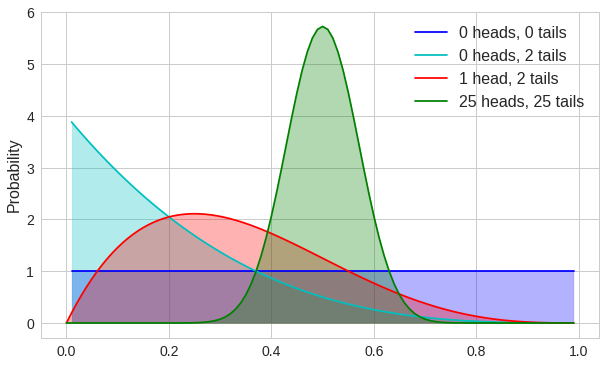

In [11]:
a = BetaDistribution(0+1, 0+1)
b = BetaDistribution(0+1, 2+2)
c = BetaDistribution(1+1, 2+2)
d = BetaDistribution(25+1, 25+1)

plt.figure(figsize=(10, 6))

x = numpy.arange(0, 1, 0.01)
ya = map( a.probability, x )
yb = map( b.probability, x )
yc = map( c.probability, x )
yd = map( d.probability, x )

plt.plot(x, ya, c='b', label="0 heads, 0 tails")
plt.plot(x, yb, c='c', label="0 heads, 2 tails")
plt.plot(x, yc, c='r', label="1 head, 2 tails")
plt.plot(x, yd, c='g', label="25 heads, 25 tails")

plt.fill_between(x, 0, ya, color='b', alpha=0.3)
plt.fill_between(x, 0, yb, color='c', alpha=0.3)
plt.fill_between(x, 0, yc, color='r', alpha=0.3)
plt.fill_between(x, 0, yd, color='g', alpha=0.3)

plt.legend()
plt.ylabel('Probability')
plt.show()

This seems intuitive. If we haven't seen any heads or any tails (blue), we really have a uniform distribution over the possible values of the probability of the coin flipping heads. If we've seen two tails (cyan) then it becomes impossible that there is a 100% chance of seeing heads, and there is a growing probability that there is a 100% probability of tails. However, as soon as we see a single head (red), the probability of only flipping tails goes to 0. This makes sense, because we've observed a head. Continuing, if we flip 10 heads and 10 tails, we get a tighter distribution around 0.5, representing our increased confidence that the parameter is around there. This makes sense, because if we flip a coin 2 times and get 1 head and 1 tail, we're less confident than if we've flipped it 2000 times and get 1000 heads and 1000 tails.

Let's apply this concept to the <i>Gossip Girl</i> data. We can start off by saying that a blast in favor of a characters agenda is a 'success', and a blast against their agenda is a 'failure'. Let's then learn beta distributions for each character for each of the four seasons, and see how these distributions evolve over time.

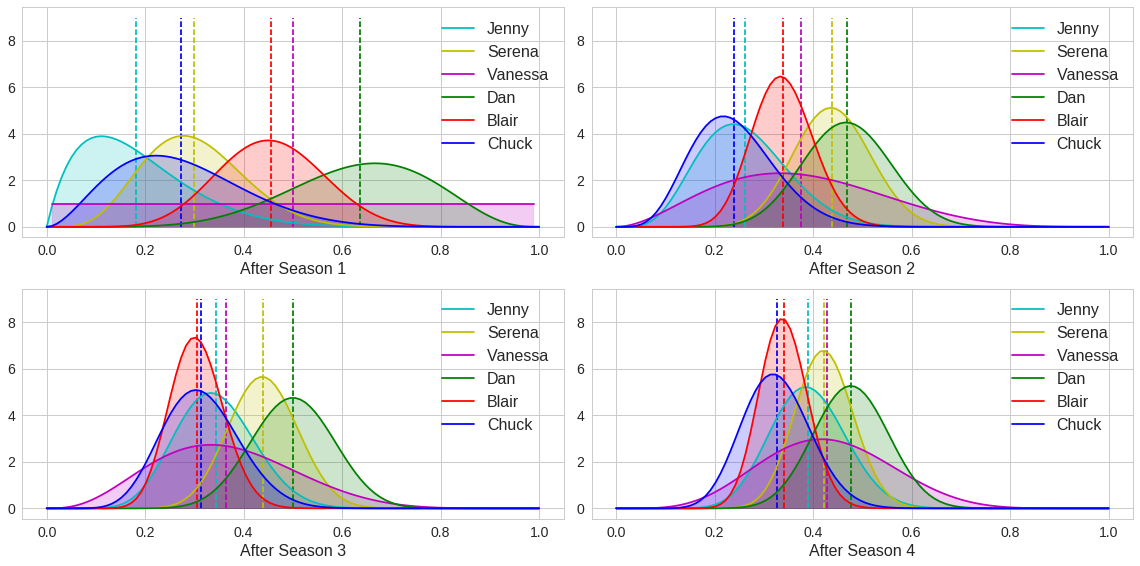

In [12]:
characters = { 
               'Blair': [[1, 1, 1, 1], [1, 1, 1, 1]],
               'Serena' : [[1, 1, 1, 1], [1, 1, 1, 1]],
               'Dan' : [[1, 1, 1, 1], [1, 1, 1, 1]],
               'Vanessa' : [[1, 1, 1, 1], [1, 1, 1, 1]],
               'Jenny' : [[1, 1, 1, 1], [1, 1, 1, 1]],
               'Chuck' : [[1, 1, 1, 1], [1, 1, 1, 1]]
             }


for i, row in data.iterrows():
    season_s = row['Season/episode']
    if isinstance( season_s, unicode ):
        season = int( row['Season/episode'][1] ) - 1 

    for character in characters.keys():
        if row[character] == 1:
            characters[character][0][season] += 1.
        elif row[character] == -1:
            characters[character][1][season] += 1.

for character, (good, bad) in characters.items():
    characters[character] = [ np.cumsum(good), np.cumsum(bad) ]

x = np.linspace(0, 1, 100)
plt.figure( figsize=(16, 8))

colors = { 
           'Blair' : 'r',
           'Serena' : 'y',
           'Dan' : 'g',
           'Jenny' : 'c',
           'Vanessa' : 'm',
           'Chuck' : 'b'
         }

for k in xrange(4):
    plt.subplot(len(good) / 2, 2, k + 1)
    plt.xlabel("After Season {}".format( k+1 ))
    
    for character, (good, bad) in characters.items():
        B = BetaDistribution(good[k], bad[k])
        y = numpy.exp([B.log_probability(i) for i in x])
        
        plt.plot( x, y, label=character, c=colors[character] )
        plt.fill_between(x, 0, y, color=colors[character], alpha=0.2)
        plt.vlines( good[k] / ( good[k]+bad[k] ), 0, 9, colors=colors[character], linestyles='dashed' )
    
    plt.legend()

plt.tight_layout()

Above we've plotted both the distributions and the maximum likelihood estimates of these distributions plotted as vertical dotted bars. We can see that over the course of the show, the distributions tighten. Two interesting observations are that Dan appears to be the favorite to be Gossip Girl across all seasons, though not by much. Also, except for by the end of Season 3, Blair is not the least likely to be Gossip Girl, being surpassed by Chuck. In fact, by the end of season 1, she is above the median for being Gossip Girl.

Hopefully this practical example has shown how even basic probabilistic modelling can be applied to derive insight in important, real world, problems.

## 2. Naive Bayes Classifiers

Now that we've covered basic probability distributions, a typical thing you may want to do is create a machine learning classifier using them. After all, you can fit these distributions to some data, and use them to evaluate the likelihood of some future points. Wouldn't it be simple to just see which distribution produced the highest likelihood of a given point, and then assign that label to the point?

This is the basis of Naive Bayes classifiers, which are a form of probabilistic classifier which rely on Bayes Rule, shown below. M stands for model, and D stands for data.

<p style="font-size:20px">
\begin{equation}
P(M|D) P(D) = P(D|M) P(M) 
\end{equation}
</p>

Let's look at the different parts of this equation. The first part of P(M|D), which is the probability of the model given the data. This is ultimately what we would like to calculate for each model (distribution) in the Naive Bayes classifier. We then return the model label corresponding to the model with the highest P(M|D) score for each point. 

However, P(D) is a bit more ambiguous. What exactly is the probability of that dataset? Instead of worrying about that, we realize that we can simply get rid of that term, since it does not depend on the model, and so will be the same for each component. We can get rid of that term, and are left with the following:

<p style="font-size:20px">
\begin{equation}
P(M|D) = P(D|M) P(M) 
\end{equation}
</p>

Next, we get to P(D|M), which is our basic likelihood function. All distributions implement `model.log_probability(X)`, which calculates logP(D|M). 

Lastly, we come to P(M), which is the prior distribution over the distributions in the Naive Bayes classifier. This term represents the probability that, without even having seeing the data point yet, we would assign a specific label to it. This typically will weight the likelihood by the frequency of that label, so that labels which occur far more frequently are recognized as being more likely. 

pomegranate implements Naive Bayes in a fast, flexible, and simple to use format. Let's see a basic example using two normal distributions.

We can specify the model in two ways, depending on if we want to fit the model to a dataset, or have specific distributions in mind which we'd like to use to predict.

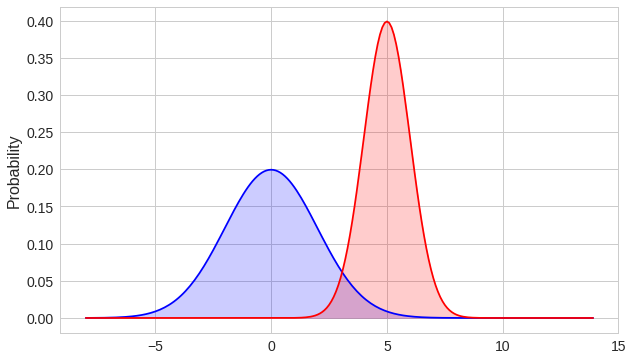

In [13]:
a = NormalDistribution(0, 2)
b = NormalDistribution(5, 1)

clf1 = NaiveBayes([a, b])
clf2 = NaiveBayes(NormalDistribution)

x = numpy.arange(-8, 14, 0.1)
ya = map( a.probability, x )
yb = map( b.probability, x )

plt.plot(x, ya, c='b')
plt.plot(x, yb, c='r')

plt.fill_between(x, 0, ya, color='b', alpha=0.2)
plt.fill_between(x, 0, yb, color='r', alpha=0.2)

plt.ylabel("Probability")
plt.show()

Let's use the predict function on a grid to see where it is predicting 0 and where it is predicting 1s, corresponding respectively to the blue and red distributions.

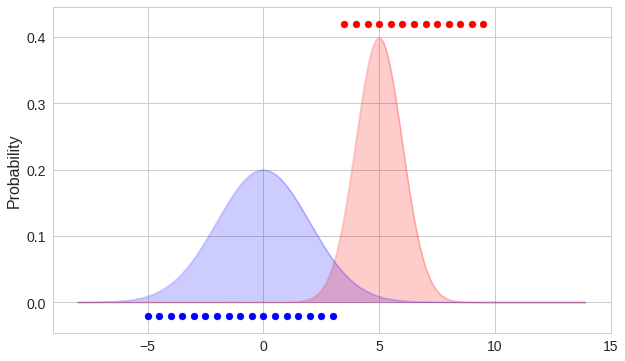

In [14]:
data = numpy.arange(-5, 10, 0.5)

y = clf1.predict(data)
n0 = data.shape[0] - y.sum()
n1 = y.sum()

x = numpy.arange(-8, 14, 0.1)
ya = map( a.probability, x )
yb = map( b.probability, x )

plt.plot(x, ya, c='b', alpha=0.2)
plt.plot(x, yb, c='r', alpha=0.2)

plt.fill_between(x, 0, ya, color='b', alpha=0.2)
plt.fill_between(x, 0, yb, color='r', alpha=0.2)

plt.scatter( data[y==0], numpy.zeros(n0)-0.02, color='b', edgecolor='b' )
plt.scatter( data[y==1], numpy.zeros(n1)+0.42, color='r', edgecolor='r' )
plt.ylabel("Probability")
plt.show()

This makes sense. The model switches from predicting 0 (blue) to 1 (red) at the position in the plot were the red distribution has a higher probability than the blue distribution. This is pretty much what we would expect from a Naive Bayes classifier with no prior distribution on the components.

Now, we can get a probabilistic view of the classification by looking at the predicted probabilities instead of just a hard classification. This ends up being P(M|D), which is a vector of probabilities that each model component generated that sample, which will sum to 1 for each sample. We can get these values by using `model.predict_proba`.

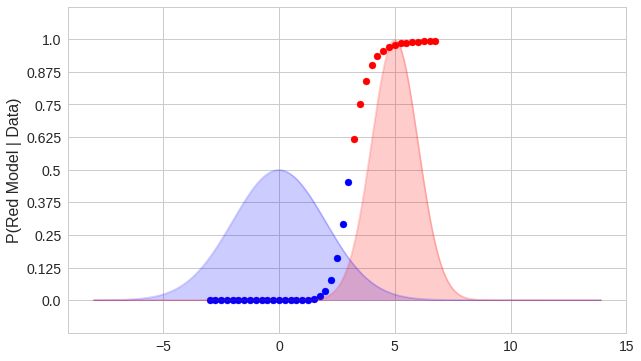

In [15]:
data = numpy.arange(-3, 7, 0.25)
y = clf1.predict_proba(data)

x = numpy.arange(-8, 14, 0.1)
ya = map( a.probability, x )
yb = map( b.probability, x )

plt.plot(x, ya, c='b', alpha=0.2)
plt.plot(x, yb, c='r', alpha=0.2)

plt.fill_between(x, 0, ya, color='b', alpha=0.2)
plt.fill_between(x, 0, yb, color='r', alpha=0.2)

plt.scatter( data[y[:,1] <= 0.5], y[y[:,1] <= 0.5, 1]*0.4, color='b', edgecolor='b' )
plt.scatter( data[y[:,1] > 0.5],  y[y[:,1] > 0.5, 1]*0.4, color='r', edgecolor='r' )

plt.yticks(numpy.arange(0, 0.41, 0.05), numpy.arange(0, 1.1, 0.125))
plt.ylim(-0.05, 0.45)
plt.ylabel("P(Red Model | Data)")
plt.show()

These results mesh pretty well with what we saw before. As the input values increases, there is a higher probability that the same was generated by the red distribution. The point at which the dots switch colors lines up with the point at which the red distribution has a higher probability than the blue distribution.

We can fit Naive Bayes classifiers in two ways. The first is by passing in an explicit list of instantiated models, possibly with a prior distribution over them, and then calling fit. The second is similar to sklearn, where we only pass a callable for the type of distribution which we would like to fit. We know the number of distributions which we'd like to fit from the label set.

In [16]:
X = numpy.concatenate([numpy.random.normal(0, 2, 100), numpy.random.normal(4, 1.5, 100)])
y = numpy.concatenate([numpy.zeros(100), numpy.ones(100)])

clf = NaiveBayes(NormalDistribution)
clf.fit(X, y)
print(clf)

{
    "models" : [
        {
            "frozen" : false,
            "class" : "Distribution",
            "parameters" : [
                -0.038891680303691736,
                2.1575102160909156
            ],
            "name" : "NormalDistribution"
        },
        {
            "frozen" : false,
            "class" : "Distribution",
            "parameters" : [
                4.217535298401316,
                1.5501007019550448
            ],
            "name" : "NormalDistribution"
        }
    ],
    "weights" : [
        0.5,
        0.5
    ],
    "class" : "NaiveBayes"
}


## Speed

sklearn implements a few versions of Naive Bayes classifiers, of which Gaussian naive bayes is probably used the most. Let's run a speed test comparing the speed of pomegranate with the speed of sklearn as well as the accuracy of the models.

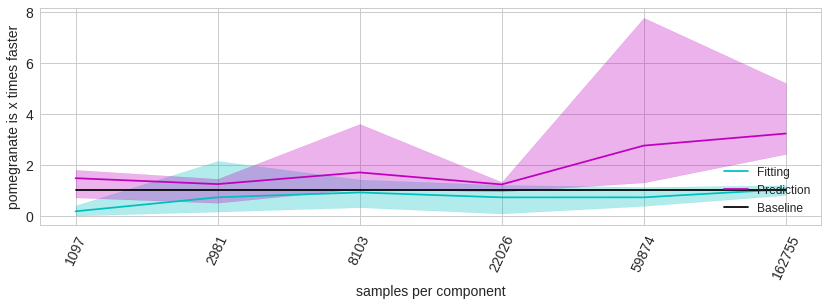

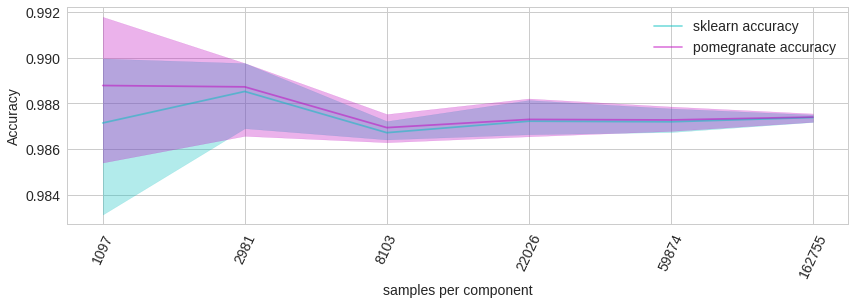

In [17]:
from sklearn.naive_bayes import GaussianNB

def create_dataset(n_samples, n_dim, n_classes):
    """Create a random dataset with n_samples in each class."""
    
    X = numpy.concatenate([numpy.random.randn(n_samples, n_dim) + i for i in range(n_classes)])
    y = numpy.concatenate([numpy.zeros(n_samples) + i for i in range(n_classes)])
    return X, y

def plot( fit, predict, skl_error, pom_error, sizes, xlabel ):
    """Plot the results."""
    
    idx = numpy.arange(fit.shape[1])
    
    plt.figure( figsize=(14, 4))
    plt.plot( fit.mean(axis=0), c='c', label="Fitting")
    plt.plot( predict.mean(axis=0), c='m', label="Prediction")
    plt.plot( [0, fit.shape[1]-1], [1, 1], c='k', label="Baseline" )
    
    plt.fill_between( idx, fit.min(axis=0), fit.max(axis=0), color='c', alpha=0.3 )
    plt.fill_between( idx, predict.min(axis=0), predict.max(axis=0), color='m', alpha=0.3 )
    
    plt.xticks(idx, sizes, rotation=65, fontsize=14)
    plt.xlabel('{}'.format(xlabel), fontsize=14)
    plt.ylabel('pomegranate is x times faster', fontsize=14)
    plt.legend(fontsize=12, loc=4)
    plt.show()
    
    
    plt.figure( figsize=(14, 4))
    plt.plot( 1 - skl_error.mean(axis=0), alpha=0.5, c='c', label="sklearn accuracy" )
    plt.plot( 1 - pom_error.mean(axis=0), alpha=0.5, c='m', label="pomegranate accuracy" )
    
    plt.fill_between( idx, 1-skl_error.min(axis=0), 1-skl_error.max(axis=0), color='c', alpha=0.3 )
    plt.fill_between( idx, 1-pom_error.min(axis=0), 1-pom_error.max(axis=0), color='m', alpha=0.3 )
    
    plt.xticks(idx, sizes, rotation=65, fontsize=14)
    plt.xlabel('{}'.format(xlabel), fontsize=14)
    plt.ylabel('Accuracy', fontsize=14)
    plt.legend(fontsize=14) 
    plt.show()
    
def evaluate_models():
    sizes = numpy.around(numpy.exp( numpy.arange(7, 13))).astype('int')
    n, m = sizes.shape[0], 5
    
    skl_predict, pom_predict = numpy.zeros((m, n)), numpy.zeros((m, n))
    skl_fit, pom_fit = numpy.zeros((m, n)), numpy.zeros((m, n))
    skl_error, pom_error = numpy.zeros((m, n)), numpy.zeros((m, n))
    
    for i in range(m):
        for j, size in enumerate(sizes):
            X, y = create_dataset(size, 20, 2)
            
            skl = GaussianNB()
            pom = NaiveBayes(MultivariateGaussianDistribution)
            
            # bench fit times
            tic = time.time()
            skl.fit( X, y )
            skl_fit[i, j] = time.time() - tic

            tic = time.time()
            pom.fit( X, y )
            pom_fit[i, j] = time.time() - tic

            # bench predict times
            tic = time.time()
            skl_predictions = skl.predict( X )
            skl_predict[i, j] = time.time() - tic

            tic = time.time()
            pom_predictions = pom.predict( X )
            pom_predict[i, j] = time.time() - tic
        
            # check number wrong
            skl_e = (y != skl_predictions).mean()
            pom_e = (y != pom_predictions).mean()

            skl_error[i, j] = min(skl_e, 1-skl_e)
            pom_error[i, j] = min(pom_e, 1-pom_e)
    
    fit = skl_fit / pom_fit
    predict = skl_predict / pom_predict
    
    plot(fit, predict, skl_error, pom_error, sizes, "samples per component")

evaluate_models()

Keep in mind that sklearn's naive bayes only learns the diagonal of the covariance matrix, whereas pomegranate is learning the full covariance matrix. This means that pomegranate is solving a harder task, and it seems like pomegranate is solving it faster for large amounts of data. This is likely due to pomegranate's BLAS backend for multivariate gaussians.

Now let's compare the speed an accuracy of the out-of-core API. pomegranate supports out-of-core learning for all models, from distributions to hidden Markov models. sklearn supports out-of-core learning for some of its models through the ue of the 'partial_fit' method. GaussianNB is one of the models which supports this method.

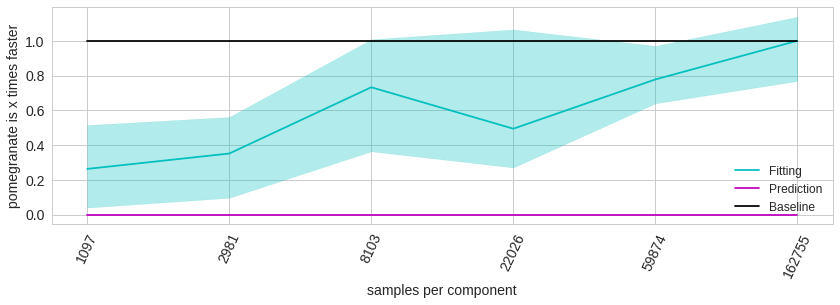

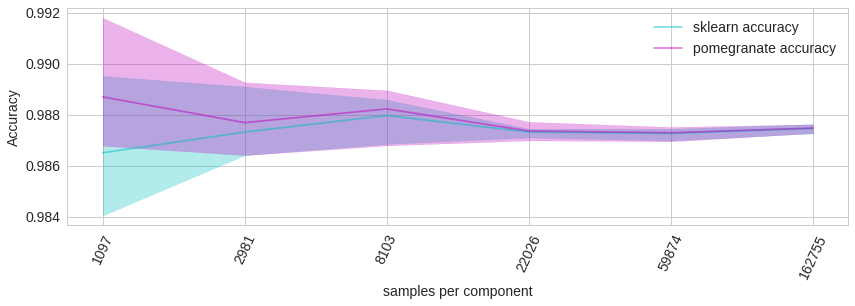

In [18]:
def evaluate_models():
    sizes = numpy.around(numpy.exp(numpy.arange(7, 13))).astype('int')
    n, m = sizes.shape[0], 5
    
    skl_time, pom_time = numpy.zeros((m, n)), numpy.zeros((m, n))
    skl_error, pom_error = numpy.zeros((m, n)), numpy.zeros((m, n))
    
    for i in range(m):
        for j, size in enumerate(sizes):
            for l in range(5):
                X, y = create_dataset( size, 20, 2 )

                skl = GaussianNB()
                pom = NaiveBayes(MultivariateGaussianDistribution)
                
                tic = time.time()
                skl.partial_fit( X, y, classes=[0, 1] )
                skl_time[i, j] += time.time() - tic

                tic = time.time()
                pom.summarize( X, y )
                pom_time[i, j] += time.time() - tic

            tic = time.time()
            pom.from_summaries()
            pom_time[i, j] += time.time() - tic

            skl_predict = skl.predict( X )
            pom_predict = pom.predict( X )

            skl_error[i, j] = ( y != skl_predict ).mean()
            pom_error[i, j] = ( y != pom_predict ).mean()
    
    fit = skl_time / pom_time
    predict = numpy.zeros_like(fit)
    
    plot(fit, predict, skl_error, pom_error, sizes, "samples per component")
    del X, y
    
evaluate_models()

It looks like with a modest amount of samples (up until ~10,000) that pomegranate can be several times faster than sklearn at training a Naive Bayes classifier. However, even if it were the same speed, pomegranate is far more flexible in terms of the type of Naive Bayes classifiers that can be trained. Let's see an example of the flexibility of Naive Bayes when it comes to using different distributions.

## Example: Classifying Noisy Signals

A common case in the analysis of signals is to have a signal which is a mixture of two different underlying phenomena, which each have different characteristics. For example, this could be the electricity usage in a house when the lights are on versus off, or a pedometer which measures when a person is running versus walking. 

Let's assume that we have a perfect segmenter right now, which will divide the signal in regions which are different from the adjacent regions. The task becomes to take this segment of the signal, and classify which phenomena are happening during it. Let's take a look at some data, colored red and blue to describe the underlying phenomena.

/home/jmschr/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:7: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


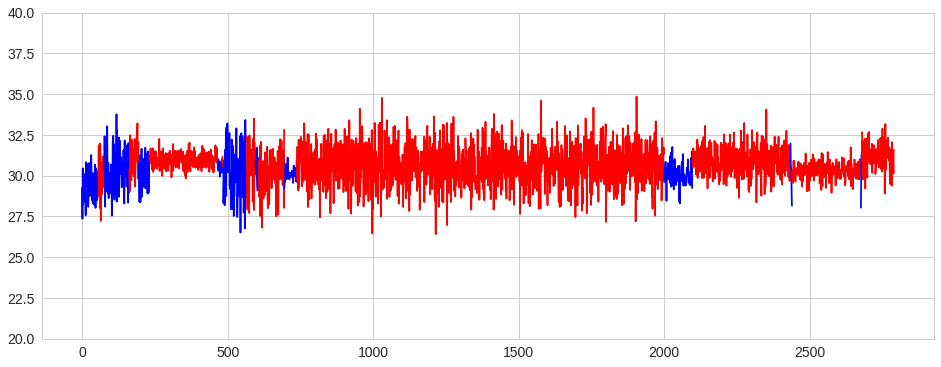

In [19]:
def plot_signal(X, n):
    plt.figure(figsize=(16, 6))

    t_current = 0
    for i in range(n):
        mu, std, t = X[i]
        chunk = numpy.random.normal(mu, std, t)
        plt.plot(numpy.arange(t_current, t_current+t), chunk, c='br'[i % 2])
        t_current += t
    
    plt.ylim(20, 40)
    plt.show()

def create_signal(n):
    X, y = [], []

    for i in range(n):
        mu = numpy.random.normal(30.0, 0.4)
        std = numpy.random.lognormal(-0.1, 0.4)
        t = int(numpy.random.exponential(45)) + 1
        X.append([mu, std, t])
        y.append(0)

        mu = numpy.random.normal(30.5, 0.4)
        std = numpy.random.lognormal(-0.4, 0.4)
        t = int(numpy.random.exponential(145)) + 1
        X.append([mu, std, t])
        y.append(1)
    
    return numpy.array(X), numpy.array(y)

X_train, y_train = create_signal(1000)
X_test, y_test = create_signal(250)
plot_signal(X_train, 20)

Each segment is drawn from a normal distribution with the mean drawn from a normal distribution, the standard deviation drawn from a log normal distribution, and the duration drawn from an exponential distribution. These distributions are all fairly similar to each other, but together they may have enough of a difference to produce a good classifier. Let's say that when the classifier gets a segment of signal, it will be classifying based on the mean, standard deviation, and duration of the signal, and now the raw data points. This turns into a basic classification task with three features.

We can create two classifers in pomegranate and also see how the more well used sklearn classifier does. One uses the appropriate underlying distribution for the features, a Normal distribution for the mean, a log normal distribution for the standard deviation, and an exponential distribution for the duration. We can wrap these all together in an IndependentComponentsDistribution, which is a multivariate distribution which models all components as independent (it can be thought of as a diagonal covariance matrix). The second classifier is a, more typical, multivariate Gaussian Naive Bayes model.

Let's fit our models to 1000 example segments, and then test the validation performance on 250 new segments.

In [20]:
from sklearn.naive_bayes import GaussianNB

d1 = NormalDistribution(0, 1)
d2 = LogNormalDistribution(0, 1)
d3 = ExponentialDistribution(0)
da = IndependentComponentsDistribution([d1, d2, d3])

d1 = NormalDistribution(0, 1)
d2 = LogNormalDistribution(0, 1)
d3 = ExponentialDistribution(0)
db = IndependentComponentsDistribution([d1, d2, d3])

model = NaiveBayes([da, db])
model.fit(X_train, y_train)
print "Naive Bayes Using Normal, LogNormal, Exponential: ", (model.predict(X_test) == y_test).mean()

model = NaiveBayes(MultivariateGaussianDistribution)
model.fit(X_train, y_train)
print "Multivariate Gaussian Naive Bayes: ", (model.predict(X_test) == y_test).mean()

clf = GaussianNB()
clf.fit(X_train, y_train)
print "sklearn Multivariate Gaussian Naive Bayes: ", ( clf.predict(X_test) == y_test).mean()

Naive Bayes Using Normal, LogNormal, Exponential:  0.802
Multivariate Gaussian Naive Bayes:  0.774
sklearn Multivariate Gaussian Naive Bayes:  0.776


Looks like using a mutlviariate Gaussian model is not a bad choice for this data, but it looks like using the proper distributions to model each of the features does allow you to get significantly better performance and generalizability. This improved performance is not just in the hard classifications, but the soft calls (using `model.predict_proba`) will be more reliable and accurate.

A difference between the pomegranate Naive Bayes clasifier and the sklearn classifier is that pomegranate will learn the full covariance matrix for the classifier, while sklearn will only learn the diagonal. In many applications, learning the full covariance matrix can improve performance as the underlying features are correlated. In this example, all of the data is generated from independent distributions, and so there isn't much correlation.

## Example: Bayesian Network Naive Bayes

Bayesian networks are just distributions which are factorized along a graphical structure. As such, we can plug them into a Naive Bayes classifier to compare different structures. For example, let's compare a Bayesian network to a simple independent components distribution. This will let us compare whether or not adding structure to the variables is better than treating them indepdently.

In [21]:
intelligence = DiscreteDistribution({0: 0.7, 1: 0.3})
difficulty   = DiscreteDistribution({0: 0.4, 1: 0.6})
SAT = ConditionalProbabilityTable([[0, 0, 0.95],
                                   [0, 1, 0.05],
                                   [1, 0, 0.20],
                                   [1, 1, 0.80]], [intelligence])
grade = ConditionalProbabilityTable([[0, 0, 0, 0.70],
                                     [0, 0, 1, 0.30],
                                     [0, 1, 0, 0.95],
                                     [0, 1, 1, 0.05],
                                     [1, 0, 0, 0.90],
                                     [1, 0, 1, 0.10],
                                     [1, 1, 0, 0.30],
                                     [1, 1, 1, 0.70]], [intelligence, difficulty])
letter = ConditionalProbabilityTable([[0, 0, 0.90],
                                      [0, 1, 0.10],
                                      [1, 0, 0.40],
                                      [1, 1, 0.60]], [grade])

s1 = State(intelligence, name="intelligence")
s2 = State(difficulty, name="difficulty")
s3 = State(SAT, name="SAT")
s4 = State(grade, name="grade")
s5 = State(letter, name="letter")

dN = BayesianNetwork()
dN.add_nodes(s1, s2, s3, s4, s5)
dN.add_edge(s1, s3)
dN.add_edge(s1, s4)
dN.add_edge(s2, s4)
dN.add_edge(s4, s5)
dN.bake()

intelligence = DiscreteDistribution({0: 0.95, 1: 0.05})
difficulty   = DiscreteDistribution({0: 0.4, 1: 0.6})
SAT = ConditionalProbabilityTable([[0, 0, 0.95],
                                   [0, 1, 0.05],
                                   [1, 0, 0.20],
                                   [1, 1, 0.80]], [intelligence])
grade = DiscreteDistribution({0: 0.2, 1: 0.8})
letter = ConditionalProbabilityTable([[0, 0, 0.90],
                                      [0, 1, 0.10],
                                      [1, 0, 0.40],
                                      [1, 1, 0.60]], [grade])

s1 = State(intelligence, name="intelligence")
s2 = State(difficulty, name="difficulty")
s3 = State(SAT, name="SAT")
s4 = State(grade, name="grade")
s5 = State(letter, name="letter")

dC = BayesianNetwork()
dC.add_nodes(s1, s2, s3, s4, s5)
dC.add_edge(s1, s3)
dC.add_edge(s4, s5)
dC.bake()

Now we have two fully created Bayesian networks, one without any dependency on grades because the student is cheating. The two changes that we make are that the distribution over intelligence favors those who are not exceptional, because they are more likely to cheat in this example. Secondly, we remove the dependency of grade on difficulty and intelligence because cheating gives a better score. 

Let's build a Naive Bayes classifier using these two networks to try to identify students who are cheating just based on this network structure.

In [22]:
X = numpy.array([[0, 0, 1, 0, 0],
                 [1, 0, 1, 1, 0],
                 [1, 1, 0, 0, 0],
                 [0, 0, 1, 0, 1],
                 [0, 0, 1, 0, 1],
                 [0, 1, 1, 0, 1],
                 [1, 0, 1, 0, 1],
                 [0, 1, 0, 1, 0]])

clf = NaiveBayes([dN, dC])
clf.predict_proba(X)

array([[ 0.72058824,  0.27941176],
       [ 0.27272727,  0.72727273],
       [ 0.96428571,  0.03571429],
       [ 0.72058824,  0.27941176],
       [ 0.72058824,  0.27941176],
       [ 0.77777778,  0.22222222],
       [ 0.96610169,  0.03389831],
       [ 0.04402516,  0.95597484]])

The student who is most likely to not be cheating makes a lot of sense. It's a smart student taking an easy class who does not do well, but does well on their SAT, and ultimately ends up getting a letter of recommendation. Conversely, the student most likely to be cheating was a poor student who was taking a difficult class, did not end up doing well on the SAT but somehow gets a good grade in the class and does not get a letter. 

It is easy to see how these networks could be expanded to allow for more granularity at each level. For example, each grade could be the actual letter grade and SAT performance might be the number of standard deviations above or below the mean. More variables and connections could allow for more sophisticated differences between the networks. No matter how complicated these networks get, they can be fed into pomegranate.

## 3. Markov Chains

Markov Chains are a simple model based on conditional probability, where a sequence is modelled as the product of conditional probabilities. A n-th order Markov chain looks back n emissions to base its conditional probability on. For example, a 3rd order Markov chain models $P(X_{t}|X_{t−1},X_{t−2},X_{t−3})$.

However, a full Markov model needs to model the first observations, and the first n-1 observations. The first observation can't really be modelled well using $P(X_{t}|X+{t−1},X_{t−2},X_{t−3})$, but can be modelled by $P(X_{t})$. The second observation has to be modelled by $P(X_{t}|X_{t−1})$. This means that these distributions have to be passed into the Markov chain as well.

We can initialize a Markov chain easily enough by passing in a list of the distributions.

In [23]:
d1 = DiscreteDistribution({'A': 0.10, 'C': 0.40, 'G': 0.40, 'T': 0.10})
d2 = ConditionalProbabilityTable([['A', 'A', 0.10],
                                ['A', 'C', 0.50],
                                ['A', 'G', 0.30],
                                ['A', 'T', 0.10],
                                ['C', 'A', 0.10],
                                ['C', 'C', 0.40],
                                ['C', 'T', 0.40],
                                ['C', 'G', 0.10],
                                ['G', 'A', 0.05],
                                ['G', 'C', 0.45],
                                ['G', 'G', 0.45],
                                ['G', 'T', 0.05],
                                ['T', 'A', 0.20],
                                ['T', 'C', 0.30],
                                ['T', 'G', 0.30],
                                ['T', 'T', 0.20]], [d1])

model = MarkovChain([d1, d2])

Markov chains have log probability, fit, summarize, and from summaries methods implemented. They do not have classification capabilities by themselves, but when combined with a Naive Bayes classifier can be used to do discrimination between multiple models.

Let's see the log probability of some data.

In [24]:
model.log_probability( list('CAGCATCAGT') ) 

-17.532789486599906

In [25]:
model.log_probability( list('C') )

-0.916290731874155

In [26]:
model.log_probability( list('CACATCACGACTAATGATAAT') )

-38.55615991599665

We can fit the model to sequences which we pass in, and as expected, see that these sequences subsequently have a higher likelihood.

In [27]:
model.fit( map( list, ('CAGCATCAGT', 'C', 'ATATAGAGATAAGCT', 'GCGCAAGT', 'GCATTGC', 'CACATCACGACTAATGATAAT') ) )
print model.log_probability( list('CAGCATCAGT') ) 
print model.log_probability( list('C') )
print model.log_probability( list('CACATCACGACTAATGATAAT') )

-9.49627091139
-0.69314718056
-25.2575143893


After fitting, we can take a look at the initial distribution and see that it has different parameters now.

In [28]:
print model.distributions[0] 

{
    "frozen" :false,
    "class" :"Distribution",
    "parameters" :[
        {
            "A" :0.16666666666666666,
            "C" :0.5,
            "T" :0.0,
            "G" :0.33333333333333331
        }
    ],
    "name" :"DiscreteDistribution"
}


## 4. General Mixture Models


It is frequently the case that the data you have is not explained by a single underlying distribution. If we want to try to recover the underlying distributions, we need to have a model which has multiple components. An example is the following data.

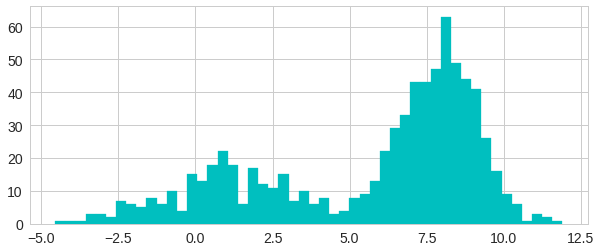

In [29]:
data = np.concatenate((np.random.normal(1, 2, (250, 1)), np.random.normal(7.85, 1.2, (500, 1))))
numpy.random.shuffle(data)

plt.figure(figsize=(10, 4))
plt.hist( data, edgecolor='c', color='c', bins=50 )
plt.show()

This data is clearly made up of two Gaussian distributions, one centered around 8, and one centered around 1. To be exact, the distributions from which the samples were generated are centered around 1 and 7.85 respectively. If we had labels for each sample, we could easily train a Naive Bayes classifier using this data, or just learn the two underlying distributions simply by grouping points with the same label and fitting a Gaussian to that data.

Unfortunately, we don't have labels for these data points. Without labels for this data, we can't directly fit a Gaussian distribution to some points. If we had explicit parameters for a distribution, we could try to infer labels based on the likelihood of each sample under each distribution (like a Naive Bayes from earlier), but we don't have explicit parameters for the distributions. We're stuck in this chicken-and-egg problem of being able to figure out one given the other, but ultimately having neither. 

We can solve this problem using the Expectation-Maximization (EM) algorithm. The gist is that you start off with a rough estimate of the parameters (such as randomly choosing a sample to be the $\mu$ and use unit variance for each component in a 1d Gaussian mixture), and then you iterate between inferring labels and performing parameter updates.

<b>Expectation:</b> Calculate 'responsibility' of each component for each sample, which is the probability that component generated that sample. This sums to 1 for each sample.

<b>Maximization:</b> Use weighted maximum likelihood estimates to update the parameters of each component, with the weight being the probability of that component generating that sample.

The difficulty can be in getting an appropriate initial estimate. pomegranate current defaults to using a single iteration of kmeans clustering in order to get initial estimates. Those clusters are then used to fit the initial distributions, and EM is run to refine those estimates until convergence.

In [30]:
model = GeneralMixtureModel(NormalDistribution, n_components=2)
model.fit(data, verbose=True)

Improvement: 19.8533019487
Improvement: 3.78287487839
Improvement: 2.30047200359
Improvement: 2.20875375032
Improvement: 2.25342736397
Improvement: 2.19291191655
Improvement: 1.96520485509
Improvement: 1.59658532207
Improvement: 1.16836199194
Improvement: 0.770987858717
Improvement: 0.462724625346
Improvement: 0.256223676541
Improvement: 0.133112085065
Improvement: 0.065928511561
Total Improvement: 39.0108707879


39.01087078786941

Let's take a look both at the underlying data which was used, and at the resulting distributions and weights (prior probabilities) which were learned by the model. 

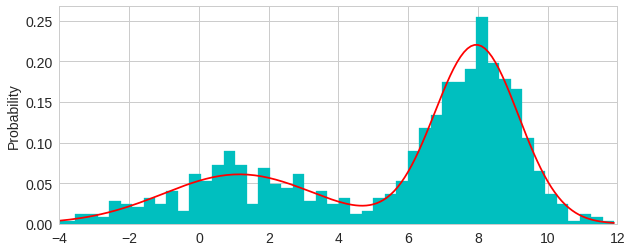

[ 0.33500473  0.66499527]


In [31]:
a, b = model.distributions

plt.figure(figsize=(10, 4))

x = numpy.arange(-4, 12, 0.1)
p = numpy.exp(model.log_probability(x))
plt.plot(x, p, color='r')
plt.hist( data, edgecolor='c', color='c', normed=True, bins=50)

plt.ylabel("Probability", fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlim(-4, 12)
plt.show()

print numpy.exp(model.weights)

It seems like it did a fairly good job on this simple example. The two learned distributions (in the background) do seem to fit what we expected that distribution to by eye. In addition, the weights are pretty spot on with the process which randomly generated the data (one third in the left hand group, two thirds in the right hand group).

We can now use these underlying distributions, and Bayes rule, to calculate the probabilities of samples having been generated from the distributions (the posterior probabiity, P(M|D)). This is the exact same calculation as the Naive Bayes classifier, since we have some underlying models and we want to know which one was most likely to have generated the sample.

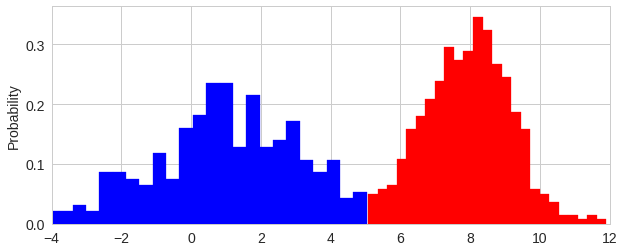

In [32]:
y = model.predict(data)

plt.figure(figsize=(10, 4))

plt.hist( data[y==0], edgecolor='b', color='b', normed=True, bins=25 )
plt.hist( data[y==1], edgecolor='r', color='r', normed=True, bins=25 )

plt.ylabel("Probability", fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlim(-4, 12)
plt.show()

Just like with the Naive Bayes classifier, we can plot the posterior probability of the two models (the distributions) over a grid of points. Since the two distributions are further away and have closer variances than the Naive Bayes example, we see a simpler logistic function representing the change in posterior probability for the two models.

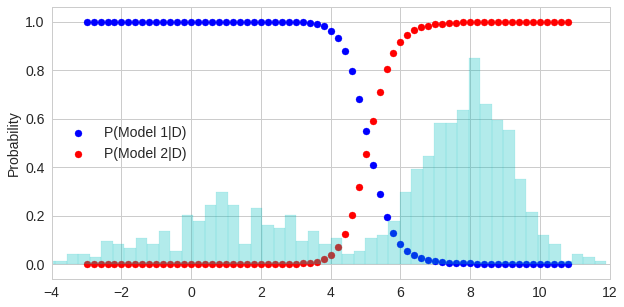

In [33]:
x = numpy.array([numpy.arange(-3, 11, .2)]).T
y = model.predict_proba(x)

plt.figure(figsize=(10, 5))

plt.hist( data, edgecolor='c', color='c', normed=True, bins=50, alpha=0.3 )
plt.scatter(x, y[:,0]*0.30, c='b', edgecolor='b',  label="P(Model 1|D)")
plt.scatter(x, y[:,1]*0.30, c='r', edgecolor='r', label="P(Model 2|D)")

plt.ylabel("Probability", fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(numpy.arange(0, 0.31, 0.06), numpy.arange(0, 1.1, 0.2), fontsize=14)
plt.xlim(-4, 12)
plt.legend(loc=6, fontsize=14)
plt.show()

The results of this make sense. But this is still pretty cool, we can take entirely unlabelled data and derive similar results to a Naive Bayes classifier, which requires labelled data. 

The reason which the model is called a General Mixture Model is because it supports mixtures of all types of distributions, not just Gaussians. This is one reason I chose to not abbreviate it to be GMM, just to make this point explicit. We can create a mixtue model of exponential distributions just as easily.

/home/jmschr/anaconda/lib/python2.7/site-packages/matplotlib/axes/_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


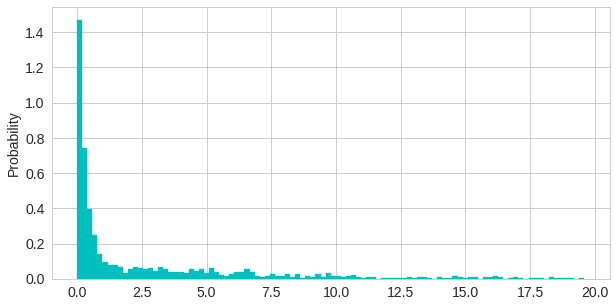

In [34]:
data = numpy.concatenate([ numpy.random.exponential(5, (1000, 1)), numpy.random.exponential(0.25, (1000, 1))])

plt.figure(figsize=(10, 5))
plt.hist( data[data < 20], edgecolor='c', color='c', normed=True, bins=100 )

plt.ylabel("Probability", fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.legend(loc=6, fontsize=14)
plt.show()

The above data was created from two exponential distributions: one with a high peak which decays early ($\lambda = 5$), and one with a lower peak which slowly decays over time ($\lambda = 0.25$). Let's fit a two component mixture model to it and see how well we are able to recover the parameters.

In [35]:
model = GeneralMixtureModel(ExponentialDistribution, n_components=2)
model.fit(data, stop_threshold=1e-8, verbose=True)

Improvement: 321.345368883
Improvement: 90.5656422536
Improvement: 47.0011392494
Improvement: 20.525894314
Improvement: 8.2584693958
Improvement: 3.25758008521
Improvement: 1.28395622718
Improvement: 0.507689995461
Improvement: 0.20141066025
Improvement: 0.0801094908493
Improvement: 0.03192093183
Improvement: 0.0127350401594
Improvement: 0.0050848223409
Improvement: 0.00203132066281
Improvement: 0.000811758936834
Improvement: 0.000324465725498
Improvement: 0.000129708901568
Improvement: 5.1857125527e-05
Improvement: 2.07334228435e-05
Improvement: 8.28987913337e-06
Improvement: 3.31463434122e-06
Improvement: 1.3253365978e-06
Improvement: 5.29944827576e-07
Improvement: 2.11891347135e-07
Improvement: 8.47308001539e-08
Improvement: 3.38845893566e-08
Improvement: 1.35441950988e-08
Improvement: 5.40740074939e-09
Total Improvement: 493.080385003


493.0803850028092

In [36]:
a, b = model.distributions
print a
print b

{
    "frozen" :false,
    "class" :"Distribution",
    "parameters" :[
        0.18644962348972974
    ],
    "name" :"ExponentialDistribution"
}
{
    "frozen" :false,
    "class" :"Distribution",
    "parameters" :[
        3.8513149393173345
    ],
    "name" :"ExponentialDistribution"
}


Looks like we can get close, but not perfect. $\lambda = 3.8$ and $\lambda = 0.2$ is close to 5 and 0.25 respectively. This is likely made more difficult by exponential distributions both overlapping each other significantly, and sharing a mode of 0. Let's take a look at what the distributions look like superimposed with the underlying data.

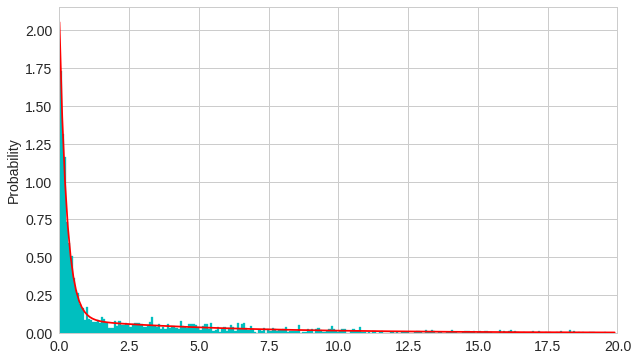

In [37]:
x = numpy.arange(0, 20, 0.1)
y = model.probability(x)
plt.plot(x, y, color='r')
plt.hist(data[data < 20], edgecolor='c', facecolor='c', normed=True, bins=250)

plt.ylabel("Probability", fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlim(0, 20)
plt.legend(loc=6, fontsize=14)
plt.show()

The fit doesn't seem too bad. Much better than we would get using Gaussians. We can also calculate the log probability under either of the distributions, and the log probability of the data under the model. This returns the log likelihood of the data, which is log P(D|M), not the posterior P(M|D).

In [38]:
print "Mixture Fit: ", model.log_probability(data).sum()
print "Exp 1 Fit :  ", sum(a.log_probability(d) for d in data)
print "Exp 2 Fit :  ", sum(b.log_probability(d) for d in data)

Mixture Fit:  -3192.78854493
Exp 1 Fit :   -4389.8167439
Exp 2 Fit :   -18591.8938074


Continuing with the theme of being a ~General~ Mixture Model, you can also manually specify any combination of pre-instantiated distributions of any types, with any priors. In this case, let's try out using an exponential distribution and a uniform distribution together, with the exponential distribution modelling the spike near 0, and the uniform distribution modelling the tail.

Improvement: 1686.04365478
Improvement: 139.605620858
Improvement: 44.8080894415
Improvement: 20.0004042164
Improvement: 10.2109099407
Improvement: 5.55966542787
Improvement: 3.13707528902
Improvement: 1.80909398236
Improvement: 1.05825314525
Improvement: 0.625146360167
Improvement: 0.371892898686
Improvement: 0.222373669803
Improvement: 0.133478309027
Improvement: 0.0803511902386
Total Improvement: 1913.66600951


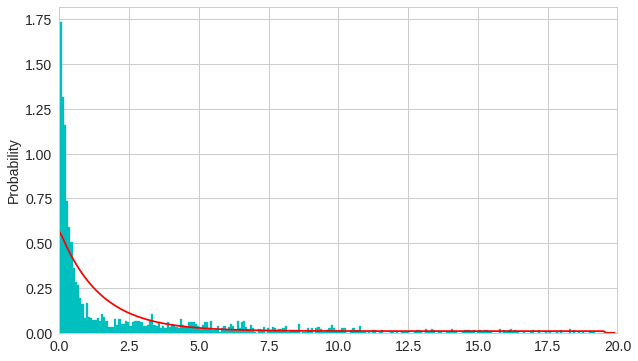

In [39]:
model = GeneralMixtureModel([ExponentialDistribution(5), UniformDistribution(0, 20)])
model.fit(data, stop_threshold=1e-1, verbose=True)

x = numpy.arange(0, 20, 0.1)
y = model.probability(x)
plt.plot(x, y, color='r')
plt.hist(data[data < 20], edgecolor='c', facecolor='c', normed=True, bins=250)


plt.ylabel("Probability", fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlim(0, 20)
plt.legend(loc=6, fontsize=14)
plt.show()

That doesn't look better than the previous fit, but this is just an example of what you ~can~ do in pomegranate, not necessarily what you ~should~ do.

## Speed

We can compare the speed of pomegranate's GMM implementation to sklearn's GMM implementation for Gaussians.

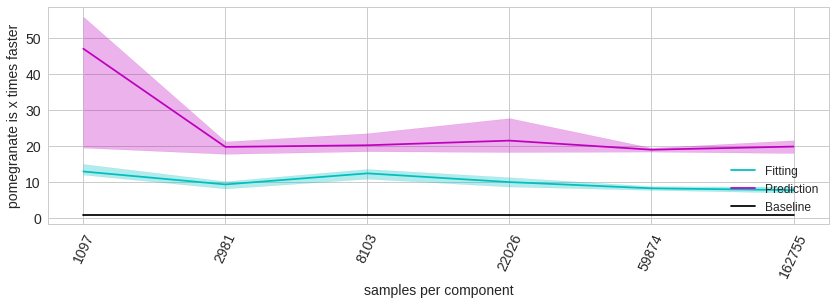

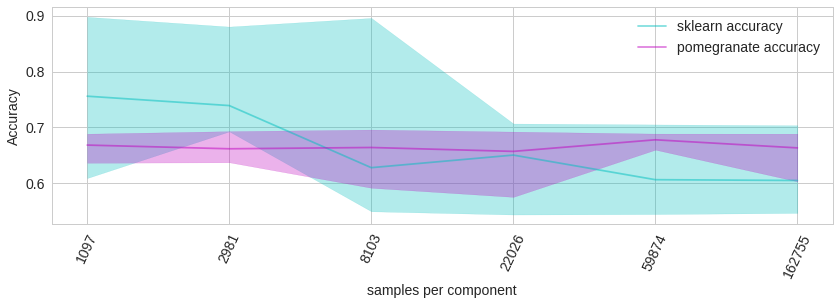

In [40]:
from sklearn.mixture import GMM

def evaluate_models():
    sizes = numpy.around( numpy.exp( numpy.arange(7, 13) ) ).astype('int')
    n, m = sizes.shape[0], 5
    
    skl_predict, pom_predict = numpy.zeros((m, n)), numpy.zeros((m, n))
    skl_fit, pom_fit = numpy.zeros((m, n)), numpy.zeros((m, n))
    skl_error, pom_error = numpy.zeros((m, n)), numpy.zeros((m, n))

    for i in range(m):
        for j, size in enumerate(sizes):
            X, y = create_dataset(size, 1, 2)

            pom = GeneralMixtureModel(NormalDistribution, n_components=2)
            skl = GMM(n_components=3, n_iter=10, tol=1e-10)
            
            # bench fit times
            tic = time.time()
            skl.fit( X )
            skl_fit[i, j] = time.time() - tic

            tic = time.time()
            pom.fit( X, max_iterations=10, stop_threshold=1e-10 )
            pom_fit[i, j] = time.time() - tic

            # bench predict times
            tic = time.time()
            skl_predictions = skl.predict( X )
            skl_predict[i, j] = time.time() - tic

            tic = time.time()
            pom_predictions = pom.predict( X )
            pom_predict[i, j] = time.time() - tic

            # check number wrong
            skl_e = (y != skl_predictions).mean()
            pom_e = (y != pom_predictions).mean()

            skl_error[i, j] = min(skl_e, 1-skl_e)
            pom_error[i, j] = min(pom_e, 1-pom_e)
    
    fit = skl_fit / pom_fit
    predict = skl_predict / pom_predict
    plot(fit, predict, skl_error, pom_error, sizes, "samples per component")
    del X, y

evaluate_models()

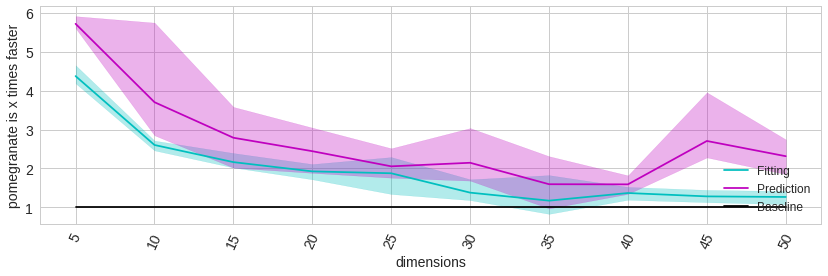

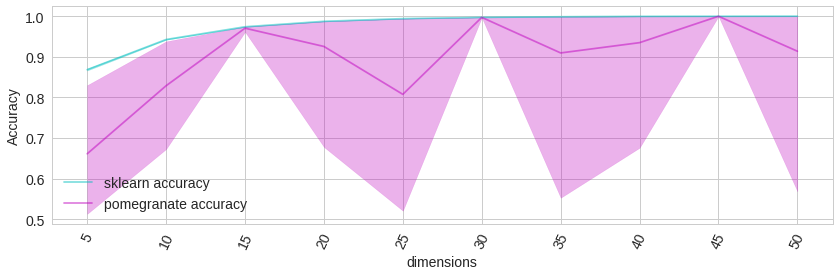

In [41]:
def evaluate_models():
    sizes = numpy.arange(5, 51, 5).astype('int')
    n, m = sizes.shape[0], 5
    
    skl_predict, pom_predict = numpy.zeros((m, n)), numpy.zeros((m, n))
    skl_fit, pom_fit = numpy.zeros((m, n)), numpy.zeros((m, n))
    skl_error, pom_error = numpy.zeros((m, n)), numpy.zeros((m, n))
    
    for i in range(m):
        for j, size in enumerate(sizes):
            X, y = create_dataset(50000, size, 2)
            
            pom = GeneralMixtureModel(MultivariateGaussianDistribution, n_components=2)
            skl = GMM(n_components=2, n_iter=10, tol=1e-10, covariance_type='full')
            
            # bench fit times
            tic = time.time()
            skl.fit( X )
            skl_fit[i, j] = time.time() - tic

            tic = time.time()
            pom.fit( X, max_iterations=10, stop_threshold=1e-10 )
            pom_fit[i, j] = time.time() - tic

            # bench predict times
            tic = time.time()
            skl_predictions = skl.predict( X )
            skl_predict[i, j] = time.time() - tic

            tic = time.time()
            pom_predictions = pom.predict( X )
            pom_predict[i, j] = time.time() - tic
        
            # check number wrong
            skl_e = (y != skl_predictions).mean()
            pom_e = (y != pom_predictions).mean()

            skl_error[i, j] = min(skl_e, 1-skl_e)
            pom_error[i, j] = min(pom_e, 1-pom_e)
    
    fit = skl_fit / pom_fit
    predict = skl_predict / pom_predict
    plot(fit, predict, skl_error, pom_error, sizes, "dimensions")
    del X, y

evaluate_models()

## Example: Classifying Noisy Signals

Let's take a look at the same example we tried in the Naive Bayes classifying case, but this time using General Mixture Models. Since GMMs and Naive Bayes can be thought of as unsupervised and supervised versions of the same technique (basically, Bayes Rule), let's try dropping the labels we had for the noisy signal segments, and see how well we can do using clustering.

In [42]:
from sklearn.mixture import GMM

X, y = create_signal(1000)

d1 = NormalDistribution(0, 1)
d2 = LogNormalDistribution(0, 1)
d3 = ExponentialDistribution(0.1)
da = IndependentComponentsDistribution([d1, d2, d3])

d1 = NormalDistribution(1, 1)
d2 = LogNormalDistribution(1, 1)
d3 = ExponentialDistribution(1)
db = IndependentComponentsDistribution([d1, d2, d3])


model = GeneralMixtureModel([da, db])
model.fit(X, stop_threshold=1e-3, max_iterations=10, verbose=False)
print "GMM Using Normal, LogNormal, Exponential: ", max((model.predict(X) == y).mean(), (1-model.predict(X) == y).mean())

model = GeneralMixtureModel(MultivariateGaussianDistribution, n_components=2)
model.fit(X_train, stop_threshold=1e-3, max_iterations=10, verbose=False)
print "Multivariate Gaussian Naive Bayes: ", max((model.predict(X) == y).mean(), (1-model.predict(X) == y).mean())

clf = GMM(n_components=2, tol=1e-3, n_iter=10)
clf.fit(X_train)
print "sklearn Multivariate Gaussian Naive Bayes: ", max((model.predict(X) == y).mean(), (1-model.predict(X) == y).mean())

GMM Using Normal, LogNormal, Exponential:  0.7745
Multivariate Gaussian Naive Bayes:  0.693
sklearn Multivariate Gaussian Naive Bayes:  0.693


Looks like we're doing significantly better using appropriate distributions than we do when we try to use Gaussian distributions. In fact, we're getting similar performance to the Naive Bayes classifier which used supervised learning. A good note is that our implementation of Gaussian mixtures and sklearns both give the exact same results when the same restraints are put on the EM algorithm

## Example: Mixtures of Hidden Markov Models

In the same vein as how it is easy to view a GMM as a "distribution" which could be used in larger models, hidden Markov models are just a structured distribution over sequences. Now, since HMMs are just a distribution, we can create a mixture of HMMs which can operate over arbitrarily lengthed sequences of data in the same way we created a mixture of anything else.

In [43]:
def build_model(a, b, name):
    d1 = State(NormalDistribution(a, 1), "d1")
    d2 = State(NormalDistribution(b, 1), "d2")

    model = HiddenMarkovModel(name)
    model.add_states(d1, d2)

    model.add_transition(model.start, d1, 0.9)
    model.add_transition(model.start, d2, 0.1)
    model.add_transition(d1, d2, 0.65)
    model.add_transition(d1, d1, 0.20)
    model.add_transition( d1, model.end, 0.15)
    model.add_transition(d2, d1, 0.20)
    model.add_transition(d2, d2, 0.70)
    model.add_transition(d2, model.end, 0.10)

    model.bake()
    return model

a = build_model(1, 7, "a")
b = build_model(3, 10, "b")
gmm = GeneralMixtureModel([a, b])

It was just as simple to make a mixture of GMMs as it is to make a mixture of any other model. Doing this may be simple if everything were a python object, but one of the benefits of pomegranate is that even though they are stacked, these objects will still using a cython backend with the GIL released when communicating with each other, as opposed to simply having a python wrapper around cythonized functions. This makes the process faster, and makes multithreading far more efficient.

Now let's take a look at the two HMMs prior to training. We can see that they have the same graph structure and edge probabilities, but the emission distributions on the two are different.

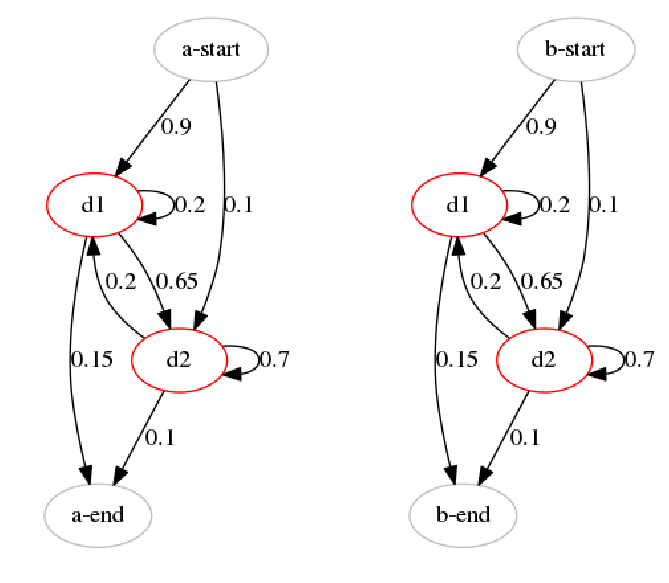

In [44]:
plt.figure(figsize=(12, 10))
plt.subplot(121)
a.plot()

plt.subplot(122)
b.plot()

plt.show()

We can now generate a bunch of data from the two underlying HMMs in order to train our model. Let's generate twice as much data from the second HMM as the first one to see if the mixture can learn the appropriate weighting (prior distribution) on the two models as well.

In [45]:
X = [ a.sample() for i in range(5) ] + [ b.sample() for i in range(10) ]
gmm.predict_proba(X)

array([[ 1.        ,  0.        ],
       [ 0.99985994,  0.00014006],
       [ 1.        ,  0.        ],
       [ 1.        ,  0.        ],
       [ 1.        ,  0.        ],
       [ 0.        ,  1.        ],
       [ 0.0053901 ,  0.9946099 ],
       [ 0.05721983,  0.94278017],
       [ 0.        ,  1.        ],
       [ 0.0000239 ,  0.9999761 ],
       [ 0.        ,  1.        ],
       [ 0.        ,  1.        ],
       [ 0.00010857,  0.99989143],
       [ 0.00000051,  0.99999949],
       [ 0.        ,  1.        ]])

We can see that the samples seem to mostly come from one model or the other. The first five are more likely to come from the first HMM, which makes sense given that they were generated by it, while the last ten sequences were more likely to come from the second HMM, which they were generated from.

Now, we can fit our model just as simply as before. Let's get a larger amount of data here to get an appropriate training set.

In [46]:
X = [ a.sample() for i in range(100) ] + [ b.sample() for i in range(200) ]
gmm.fit(X, verbose=True)

Improvement: 30.8726176135
Improvement: 0.324111329346
Improvement: 0.0336743296757
Total Improvement: 31.2304032725


31.230403272528747

We can now take a look at the underlying graphs again to see that the edge probabilities for the two have shifted. We cannot see the emissions on this graph, but we could extract the explicit distributions from the model itself if we so wanted.

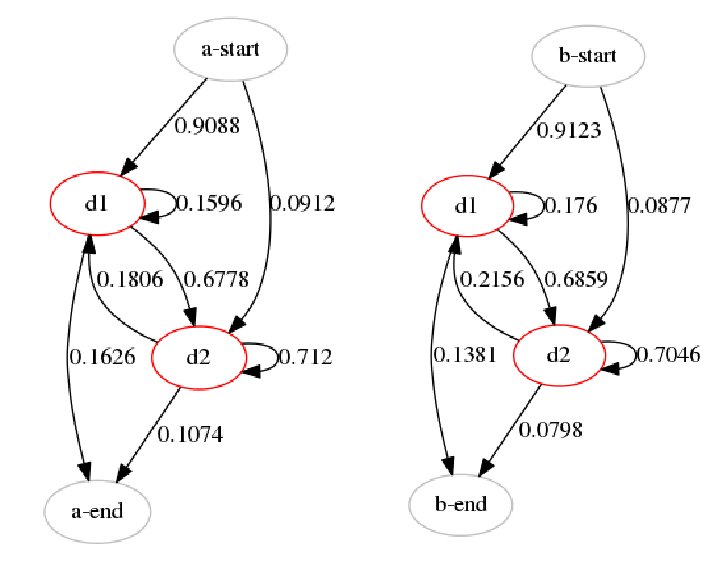

In [47]:
plt.figure(figsize=(12, 10))
plt.subplot(121)
a.plot()

plt.subplot(122)
b.plot()

plt.show()

We can now look at the weight of each component in the mixture. This should be 0.33 and 0.66 respectively, since that's the relative frequency with which we generated data. 

In [48]:
numpy.exp(gmm.weights)

array([ 0.33183075,  0.66816925])

Great. In addition to updating model parameters in an unsupervised manner, we're able to learn the prior distribution of the two components based on their frequency in the underlying data.

## 5. Hidden Markov Models

Hidden Markov models (HMMs) are the flagship of the pomegranate package, in that the majority of my time has been spent improving their performance, and these improvements trickle down into other models which use the same components. As such, they are very high performing and very feature rich. Let's compare the feature set between pomegranate and hmmlearn, which is another package which implements hidden Markov models in Python.

<table>
<tr>
<th>Feature</th>
<th>pomegranate</th>
<th>hmmlearn</th>
</tr>
<tr>
<th>Graph Structure</th>
<th></th>
<th></th>
</tr>
<tr>
<td>Silent States</td>
<td>&#10003;</td>
<td></td>
</tr>
<tr>
<td>Optional Explicit End State</td>
<td>&#10003;</td>
<td></td>
</tr>
<tr>
<td>Sparse Implementation</td>
<td>&#10003;</td>
<td></td>
</tr>
<tr>
<td>Arbitrary Emissions Allowed on States</td>
<td>&#10003;</td>
<td></td>
</tr>
<tr>
<td>Discrete/Gaussian/GMM Emissions</td>
<td>&#10003;</td>
<td>&#10003;</td>
</tr>
<tr>
<td>Large Library of Other Emissions</td>
<td>&#10003;</td>
<td></td>
</tr>
<tr>
<td>Build Model from Matrices</td>
<td>&#10003;</td>
<td>&#10003;</td>
</tr>
<tr>
<td>Build Model Node-by-Node</td>
<td>&#10003;</td>
<td></td>
</tr>
<tr>
<td>Serialize to JSON</td>
<td>&#10003;</td>
<td></td>
</tr>
<tr>
<td>Serialize using Pickle/Joblib</td>
<td>&#10003;</td>
<td>&#10003;</td>
</tr>
<tr>
<th>Algorithms</th>
<th></th>
<th></th>
</tr>
<tr>
<td>Priors</td>
<td></td>
<td>&#10003;</td>
</tr>
<tr>
<td>Sampling</td>
<td>&#10003;</td>
<td>&#10003;</td>
</tr>
<tr>
<td>Log Probability Scoring</td>
<td>&#10003;</td>
<td>&#10003;</td>
</tr>
<tr>
<td>Forward-Backward Emissions</td>
<td>&#10003;</td>
<td>&#10003;</td>
</tr>
<tr>
<td>Forward-Backward Transitions</td>
<td>&#10003;</td>
<td></td>
</tr>
<tr>
<td>Viterbi Decoding</td>
<td>&#10003;</td>
<td>&#10003;</td>
</tr>
<tr>
<td>MAP Decoding</td>
<td>&#10003;</td>
<td>&#10003;</td>
</tr>
<tr>
<td>Baum-Welch Training</td>
<td>&#10003;</td>
<td>&#10003;</td>
</tr>
<tr>
<td>Viterbi Training</td>
<td>&#10003;</td>
<td></td>
</tr>
<tr>
<td>Labeled Training</td>
<td>&#10003;</td>
<td></td>
</tr>
<tr>
<td>Tied Emissions</td>
<td>&#10003;</td>
<td></td>
</tr>
<tr>
<td>Tied Transitions</td>
<td>&#10003;</td>
<td></td>
</tr>
<tr>
<td>Emission Inertia</td>
<td>&#10003;</td>
<td></td>
</tr>
<tr>
<td>Transition Inertia</td>
<td>&#10003;</td>
<td></td>
</tr>
<tr>
<td>Emission Freezing</td>
<td>&#10003;</td>
<td>&#10003;</td>
</tr>
<tr>
<td>Transition Freezing</td>
<td>&#10003;</td>
<td>&#10003;</td>
</tr>
<tr>
<td>Multi-threaded Training</td>
<td>&#10003;</td>
<td></td>
</tr>

</table>
</p>


Hidden Markov models are a form of structured prediction method which extend general mixture models to sequences of data, where position in the sequence is relevant. If each point in this sequence is completely independent of the other points, then HMMs are not the right tools and GMMs (or more complicated Bayesian networks) may be a better tool.
The most common examples of HMMs come from bioinformatics and natural language processing. Since I am a bioinformatician, I will predominately use examples from bioinformatics.

## Speed

hmmlearn is a package for hidden Markov models with a scikit-learn like API. Let's compare the speed of pomegranate versus the speed of hmmlearn when it comes to a sparse graph with discrete emissions, such as those which are commonly seen in bioinformatics settings.

/home/jmschr/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:79: DeprecationWarning: converting an array with ndim > 0 to an index will result in an error in the future


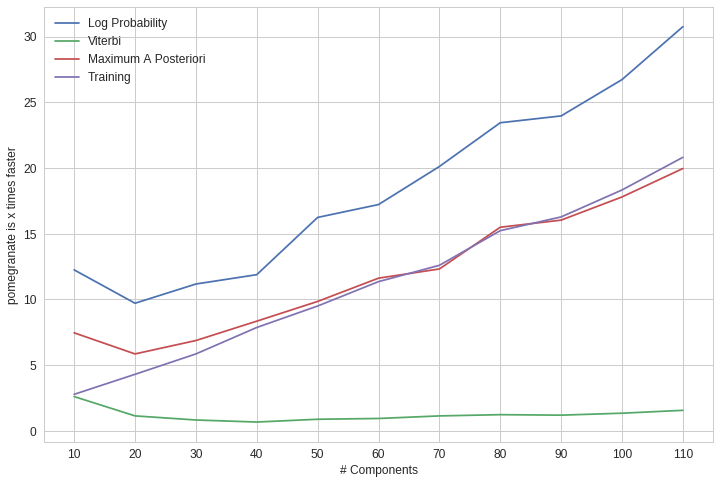

In [49]:
from hmmlearn.hmm import *

def initialize_components(n_components, n_seqs):
    """
    Initialize a transition matrix for a model with a fixed number of components,
    for Gaussian emissions with a certain number of dimensions, and a data set
    with a certain number of sequences.
    """
    
    transmat = numpy.zeros((n_components, n_components))
    transmat[-1, -1] = 1
    for i in range(n_components-1):
        transmat[i, i] = 1
        transmat[i, i+1] = 1
    transmat[ transmat < 0 ] = 0
    transmat = (transmat.T / transmat.sum( axis=1 )).T
    
    start_probs = numpy.abs( numpy.random.randn(n_components) )
    start_probs /= start_probs.sum()

    dists = numpy.abs(numpy.random.randn(n_components, 4))
    dists = (dists.T / dists.T.sum(axis=0)).T
    
    seqs = numpy.random.randint(0, 4, (n_seqs, n_components*2, 1))
    return transmat, start_probs, dists, seqs

def hmmlearn_model(transmat, start_probs, dists):
    """Return a hmmlearn model."""

    model = MultinomialHMM(n_components=transmat.shape[0], n_iter=1, tol=1e-8)
    model.startprob_ = start_probs
    model.transmat_ = transmat
    model.emissionprob_ = dists
    return model

def pomegranate_model(transmat, start_probs, dists):
    """Return a pomegranate model."""
    
    states = [ DiscreteDistribution({ 'A': d[0],
                                      'C': d[1],
                                      'G': d[2], 
                                      'T': d[3] }) for d in dists ]
    model = HiddenMarkovModel.from_matrix(transmat, states, start_probs, merge='None')
    return model

def evaluate_models(n_seqs):
    hllp, plp = [], []
    hlv, pv = [], []
    hlm, pm = [], []
    hls, ps = [], []
    hlt, pt = [], []

    dna = 'ACGT'
    
    for i in range(10, 112, 10):
        transmat, start_probs, dists, seqs = initialize_components(i, n_seqs)
        model = hmmlearn_model(transmat, start_probs, dists)

        tic = time.time()
        for seq in seqs:
            model.score(seq)
        hllp.append( time.time() - tic )

        tic = time.time()
        for seq in seqs:
            model.predict(seq)
        hlv.append( time.time() - tic )

        tic = time.time()
        for seq in seqs:
            model.predict_proba(seq)
        hlm.append( time.time() - tic )    
        
        tic = time.time()
        model.fit(seqs.reshape(n_seqs*i*2, 1), lengths=[i*2]*n_seqs)
        hlt.append( time.time() - tic )

        model = pomegranate_model(transmat, start_probs, dists)
        seqs = [[dna[i] for i in seq] for seq in seqs]

        tic = time.time()
        for seq in seqs:
            model.log_probability(seq)
        plp.append( time.time() - tic )

        tic = time.time()
        for seq in seqs:
            model.predict(seq)
        pv.append( time.time() - tic )

        tic = time.time()
        for seq in seqs:
            model.predict_proba(seq)
        pm.append( time.time() - tic )    
        
        tic = time.time()
        model.fit(seqs, max_iterations=1, verbose=False)
        pt.append( time.time() - tic )

    plt.figure( figsize=(12, 8))
    plt.xlabel("# Components", fontsize=12 )
    plt.ylabel("pomegranate is x times faster", fontsize=12 )
    plt.plot( numpy.array(hllp) / numpy.array(plp), label="Log Probability")
    plt.plot( numpy.array(hlv) / numpy.array(pv), label="Viterbi")
    plt.plot( numpy.array(hlm) / numpy.array(pm), label="Maximum A Posteriori")
    plt.plot( numpy.array(hlt) / numpy.array(pt), label="Training")
    plt.xticks( xrange(11), xrange(10, 112, 10), fontsize=12 )
    plt.yticks( fontsize=12 )
    plt.legend( fontsize=12 )
    
evaluate_models(50)

Let's look at an example case where we compare the performance of a sparse HMM with discrete emisions, such as those common in bionformatic settings (such as sequence alignment). This is a case that pomegranate should do very well at due to its sparse implementation of hidden Markov models.

Let's take the simplified example of CG island detection on a sequence of DNA. DNA is made up of the four canonical nucleotides, abbreviated 'A', 'C', 'G', and 'T'. Specific organizations of these nucleotides encode enough information to build you, a human being. One simple region in the genome is called the 'CG' island, where the nucleotides 'C' and 'G' are enriched. Let's implement a CG island detector in pomegranate to see how simple it is to build structured modls.

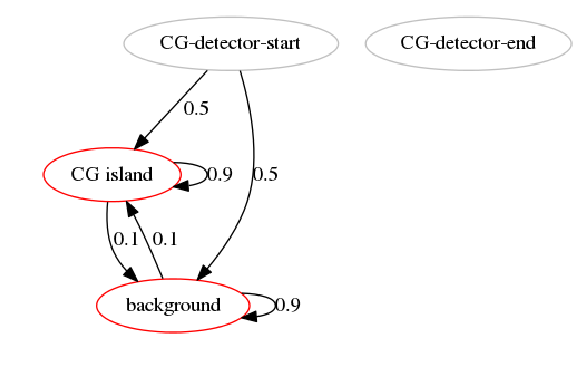

In [50]:
d1 = DiscreteDistribution({'A': 0.25, 'C': 0.25, 'G': 0.25, 'T': 0.25})
d2 = DiscreteDistribution({'A': 0.10, 'C': 0.40, 'G': 0.40, 'T': 0.10})

s1 = State(d1, name="background")
s2 = State(d2, name="CG island")

hmm = HiddenMarkovModel("CG-detector")
hmm.add_states(s1, s2)
hmm.add_transition(hmm.start, s1, 0.5)
hmm.add_transition(hmm.start, s2, 0.5)
hmm.add_transition(s1, s1, 0.9)
hmm.add_transition(s1, s2, 0.1)
hmm.add_transition(s2, s1, 0.1)
hmm.add_transition(s2, s2, 0.9)
hmm.bake()
hmm.plot()
plt.show()

In [51]:
seq = list("CGACTACTGACTACTCGCGCGCACGCGGCACGCGTGCCGTCTATACTGCGCATACGGC")
hmm_predictions = hmm.predict( seq )

print "sequence: {}".format( ''.join( seq ) )

print "hmm pred: {}".format( ''.join( map( str, hmm_predictions ) ) )
print
print "hmm state 0: {}".format( hmm.states[0].name )
print "hmm state 1: {}".format( hmm.states[1].name )

sequence: CGACTACTGACTACTCGCGCGCACGCGGCACGCGTGCCGTCTATACTGCGCATACGGC
hmm pred: 1111111111111110000000000000000000000001111111111111110000

hmm state 0: CG island
hmm state 1: background


This seems fairly reasonable, and the HMM was able to find the single CG island in the middle of the sequence. However, it also found something at the end of the sequence which it called a CG island. Let's say that we want to enforce that the model cannot end on a CG island. We can do this by changing the structure of the model to add an exit distribution in addition to the start distribution and transition matrix.

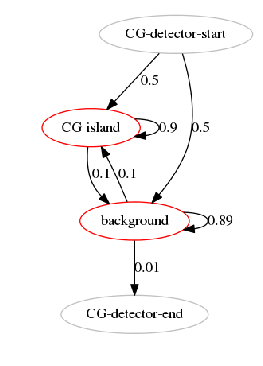

In [52]:
hmm = HiddenMarkovModel("CG-detector")
hmm.add_states(s1, s2)
hmm.add_transition(hmm.start, s1, 0.5)
hmm.add_transition(hmm.start, s2, 0.5)
hmm.add_transition(s1, s1, 0.89)
hmm.add_transition(s1, s2, 0.10)
hmm.add_transition(s1, hmm.end, 0.01)
hmm.add_transition(s2, s1, 0.1)
hmm.add_transition(s2, s2, 0.9)
hmm.bake()
hmm.plot()
plt.show()

In [53]:
hmm_predictions = hmm.predict( seq )

print "sequence: {}".format( ''.join( seq ) )
print "hmm pred: {}".format( ''.join( map( str, hmm_predictions ) ) )
print
print "hmm state 0: {}".format( hmm.states[0].name )
print "hmm state 1: {}".format( hmm.states[1].name )

sequence: CGACTACTGACTACTCGCGCGCACGCGGCACGCGTGCCGTCTATACTGCGCATACGGC
hmm pred: 1111111111111110000000000000000000000001111111111111111111

hmm state 0: CG island
hmm state 1: background


Looks like we managed to get rid of that pesky end (again, the numbers may have flipped, look at the indices). Modifying transition probabilities and using non-dense graphical structures are two major ways in which HMMs account for data in a sequence not being independent and identically distributed (i.i.d.). In fact, in most applications, the graphical structure of a HMM is very sparse.
If we want a more probabilistic view of what's going on, we can get the probability of each symbol in the sequence being in each of the states in the model easily. This is useful to get a soft estimate of classification, which allows us to include confidence as well as prediction. Values close to 50-50 get masked when you make hard classifications, but this uncertainty can be passed to future applications if you use soft assignments. Each row in the matrix is one symbol in the sequence, and the columns correspond to the two states identified above (CG island or background).

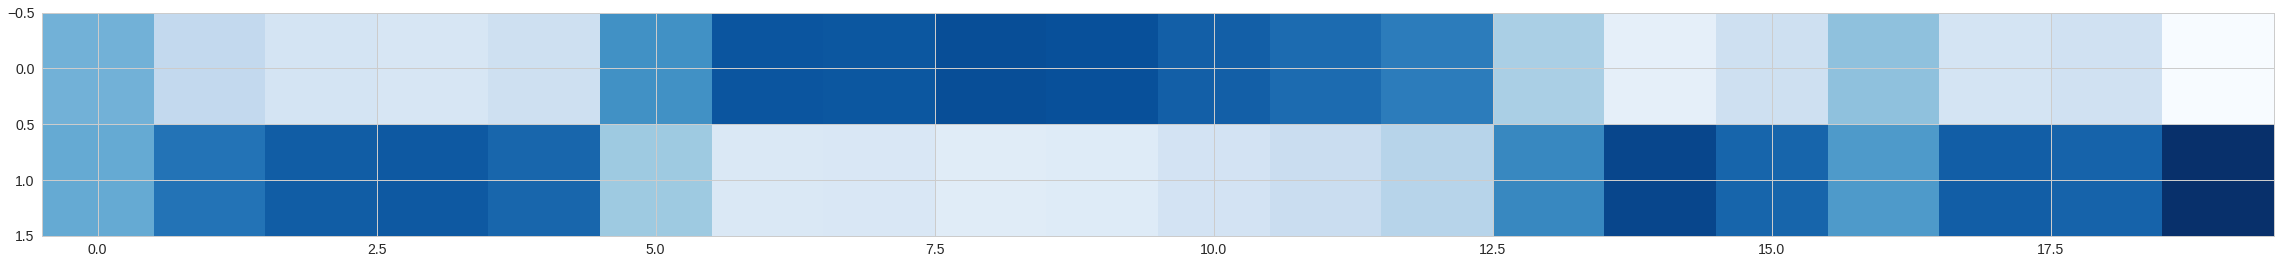

In [54]:
plt.figure(figsize=(40, 30))
plt.imshow( hmm.predict_proba(seq)[::3].T, interpolation='nearest', cmap='Blues' )
plt.show()

## Adding More Structure to CpG Island Detector

So far we've dealt with a dense HMM, where edges existed between all states in the graph. However, pomegranate efficiently implements sparse HMMs, where the only edge which are stored are those with nonzero values. This makes the model take significantly less memory, and also increases computational speed versus using the full matrix. 

Let's see an example with this. Let's consider the idea that we know there are three CpG islands in a sequence. We don't know where they occur, but we know that there are exactly 3, and that they all occur somewhere. Pursuing this example will allow us to investigate multiple aspects of HMM training which pomegranate supports.

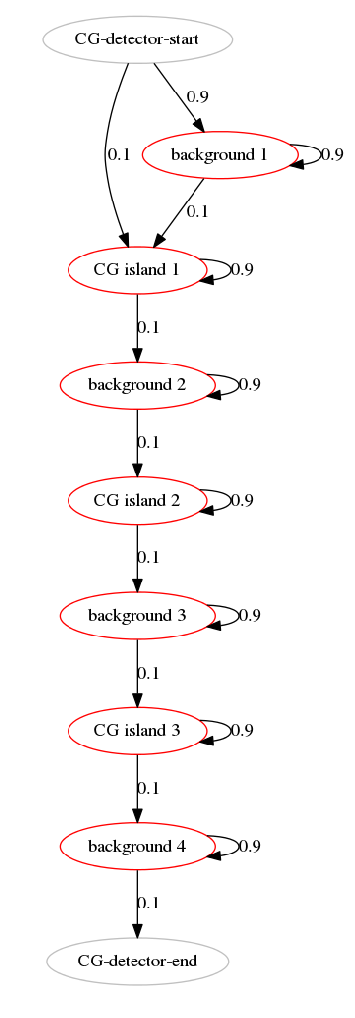

In [55]:
d1 = DiscreteDistribution({'A': 0.25, 'C': 0.25, 'G': 0.25, 'T': 0.25})
d2 = DiscreteDistribution({'A': 0.10, 'C': 0.40, 'G': 0.40, 'T': 0.10})
d3 = DiscreteDistribution({'A': 0.25, 'C': 0.25, 'G': 0.25, 'T': 0.25})
d4 = DiscreteDistribution({'A': 0.10, 'C': 0.40, 'G': 0.40, 'T': 0.10})
d5 = DiscreteDistribution({'A': 0.25, 'C': 0.25, 'G': 0.25, 'T': 0.25})
d6 = DiscreteDistribution({'A': 0.10, 'C': 0.40, 'G': 0.40, 'T': 0.10})
d7 = DiscreteDistribution({'A': 0.25, 'C': 0.25, 'G': 0.25, 'T': 0.25})

s1 = State(d1, name='background 1')
s2 = State(d2, name='CG island 1')
s3 = State(d3, name='background 2')
s4 = State(d4, name='CG island 2')
s5 = State(d5, name='background 3')
s6 = State(d6, name='CG island 3')
s7 = State(d7, name='background 4')

model = HiddenMarkovModel("CG-detector")
model.add_states(s1, s2, s3, s4, s5, s6, s7)
model.add_transition(model.start, s1, 0.9)
model.add_transition(model.start, s2, 0.1)
model.add_transition(s1, s1, 0.90)
model.add_transition(s1, s2, 0.10)
model.add_transition(s2, s3, 0.10)
model.add_transition(s2, s2, 0.90)
model.add_transition(s3, s3, 0.90)
model.add_transition(s3, s4, 0.10)
model.add_transition(s4, s5, 0.10)
model.add_transition(s4, s4, 0.90)
model.add_transition(s5, s5, 0.90)
model.add_transition(s5, s6, 0.10)
model.add_transition(s6, s7, 0.10)
model.add_transition(s6, s6, 0.90)
model.add_transition(s7, s7, 0.90)
model.add_transition(s7, model.end, 0.10)
model.bake()

plt.figure(figsize=(6, 18))
model.plot()
plt.show()

In [56]:
seq = list("CGACTACGCTGCACTACTCGCGCGCATCTATACGCCGCGGCATCTCCGCGTGCCGTCTATACTGCGCATACGGC")

hmm_predictions = hmm.predict( seq, algorithm='viterbi' )[1:-1]
model_predictions = model.predict( seq, algorithm='viterbi' )[1:-1]

print "sequence: {}".format( ''.join( seq ) )
print "hmm pred: {}".format( ''.join( map( str, hmm_predictions ) ) )
print "3GC pred: {}".format( ''.join( map( str, model_predictions ) ) )
print
print "hmm state 0: {}".format( hmm.states[0].name )
print "hmm state 1: {}".format( hmm.states[1].name )
print
print "3GC state 0: {}".format( model.states[0].name )
print "3GC state 1: {}".format( model.states[1].name )
print "3GC state 2: {}".format( model.states[2].name )
print "3GC state 3: {}".format( model.states[3].name )
print "3GC state 4: {}".format( model.states[4].name )
print "3GC state 5: {}".format( model.states[5].name )
print "3GC state 6: {}".format( model.states[6].name )

sequence: CGACTACGCTGCACTACTCGCGCGCATCTATACGCCGCGGCATCTCCGCGTGCCGTCTATACTGCGCATACGGC
hmm pred: 11111111111111111111111111111111000000000000000000000001111111111111111111
3GC pred: 33333333333333333300000004444444111111111555522222222226666666666666666666

hmm state 0: CG island
hmm state 1: background

3GC state 0: CG island 1
3GC state 1: CG island 2
3GC state 2: CG island 3
3GC state 3: background 1
3GC state 4: background 2
3GC state 5: background 3
3GC state 6: background 4


We can see that the 3GC model seems to identify the 3 GC islands significantly better than the last HMM model we had before. Adding structural regularization like this can significantly improve the quality of your model, if you have prior information on the underlying structure of the data.

However, if we were to train this model on data, we would notice some interesting results...

In [57]:
seqs = map(list, ['ATAGATCATCGACGCTACGCGCCATATATATAGACCTCGCCGCTCATATACGACTCGACACTCGATAT',
                  'GATCGACCATGCACGACTCGCATCAGCTATAAGATGAATGCCAGCGACGACTACGACGACGATCTATA',
                  'CGATAATAGCATCGACACGACGCGCGCATATAGCATCGACACGCATACATGCAACATACGACCGCTA',
                  'AGACTACGACACGACATCGCACCTACTATATAGACTCGCGCGCGCCTAAATGCACGTACGCCTAATAATATAGCTACG'])

model.fit(seqs, stop_threshold=1e-1)

Training improvement: 16.6573399577
Training improvement: 0.497436656627
Training improvement: 0.386856777734
Training improvement: 0.321034946036
Training improvement: 0.275557424901
Training improvement: 0.241483212841
Training improvement: 0.212387819671
Training improvement: 0.185136217537
Training improvement: 0.159111400528
Training improvement: 0.135366061427
Training improvement: 0.115355161683
Training improvement: 0.099593565991
Total Training Improvement: 19.2866592026


19.286659202643705

Let's take a look at two of the CG island states.

In [58]:
print model.states[1].distribution.parameters[0]
print model.states[2].distribution.parameters[0]

{'A': 0.08111462496280261, 'C': 0.5165008946612588, 'T': 0.08216457855785053, 'G': 0.32021990181808807}
{'A': 0.2858227592966243, 'C': 0.3696834168275769, 'T': 0.13351784022248617, 'G': 0.21097598365331263}


Let's also take a look at two of the background states...

In [59]:
print model.states[3].distribution.parameters[0]
print model.states[4].distribution.parameters[0]

{'A': 0.37739936644252575, 'C': 0.2426622456340626, 'T': 0.17866900448893733, 'G': 0.2012693834344743}
{'A': 0.4479860847204273, 'C': 0.11072777682293997, 'T': 0.317085260446504, 'G': 0.1242008780101286}


It looks like we're getting pretty drastically different emissions in these states, despite wanting them to model the same phenomena. It is certainly possible that each of these states should model slightly different distributions, but frequently we want them to model exactly the same emissions, but allowing for different structures. We can solve this problem through the use of tied emissions. This basically means that every observation which aligns to one CG island state is thought to be aligned to all CG island states.

We can indicated tied emissions fairly early. Specifically, we just pass the same distribution object into the State object. That's it. 

In [60]:
background = DiscreteDistribution({'A': 0.25, 'C': 0.25, 'G': 0.25, 'T': 0.25})
cg_island = DiscreteDistribution({'A': 0.10, 'C': 0.40, 'G': 0.40, 'T': 0.10})

s1 = State(background, name='background 1')
s2 = State(cg_island, name='CG island 1')
s3 = State(background, name='background 2')
s4 = State(cg_island, name='CG island 2')
s5 = State(background, name='background 3')
s6 = State(cg_island, name='CG island 3')
s7 = State(background, name='background 4')

model = HiddenMarkovModel("CG-detector")
model.add_states(s1, s2, s3, s4, s5, s6, s7)
model.add_transition(model.start, s1, 0.9)
model.add_transition(model.start, s2, 0.1)
model.add_transition(s1, s1, 0.90)
model.add_transition(s1, s2, 0.10)
model.add_transition(s2, s3, 0.10)
model.add_transition(s2, s2, 0.90)
model.add_transition(s3, s3, 0.90)
model.add_transition(s3, s4, 0.10)
model.add_transition(s4, s5, 0.10)
model.add_transition(s4, s4, 0.90)
model.add_transition(s5, s5, 0.90)
model.add_transition(s5, s6, 0.10)
model.add_transition(s6, s7, 0.10)
model.add_transition(s6, s6, 0.90)
model.add_transition(s7, s7, 0.90)
model.add_transition(s7, model.end, 0.10)
model.bake()
model.fit(seqs, stop_threshold=1e-1)

Training improvement: 15.7184318461
Training improvement: 0.127316151921
Training improvement: 0.0729768155423
Total Training Improvement: 15.9187248135


15.918724813524534

We can see that there is less training improvement. This is a good thing, because we are restraining the number of parameters which the model has. Basically, we are regularizing the model to fight overfitting, which will cause our training accuracy/improvement to be less good in order to get better generalization.

Let's take a look at the distributions.

In [61]:
print model.states[1].distribution.parameters[0]
print model.states[2].distribution.parameters[0]

{'A': 0.20104742253057367, 'C': 0.43767073623938646, 'T': 0.08961740057361418, 'G': 0.27166444065642575}
{'A': 0.20104742253057367, 'C': 0.43767073623938646, 'T': 0.08961740057361418, 'G': 0.27166444065642575}


Looks good, they have the same emissions! Let's look at background as well.

In [62]:
print model.states[3].distribution.parameters
print model.states[4].distribution.parameters

[{'A': 0.362938051161472, 'C': 0.25413487654821093, 'T': 0.22402431373533832, 'G': 0.1589027585549785}]
[{'A': 0.362938051161472, 'C': 0.25413487654821093, 'T': 0.22402431373533832, 'G': 0.1589027585549785}]


Through the use of tied emissions, we were able to ensure that distributions with the same emissions before training continue to have the same (better) emissions after fitting. This backend for this does it extremely efficiently, and should not come at a cost of computational time at all.

Let's now consider the case, where we think that we can have ~at most~ 3 CG islands, but we don't know how many will occur. We could theoretically accomplish this by adding an edge from every background state to every background state further in the chain. However, since all of the HMM algorithms take time proportional to the number of edges in the model, it would be better to try to limit this (not noticable in this case, but likely noticable in large examples). pomegranate supports 'silent states', which are states which the model can transition to, which do not correspond to a specific emission in the sequence. Basically, they can be thought of like 'secret passageways' between states. You can create a silent state by passing None in as the distribution to a state.

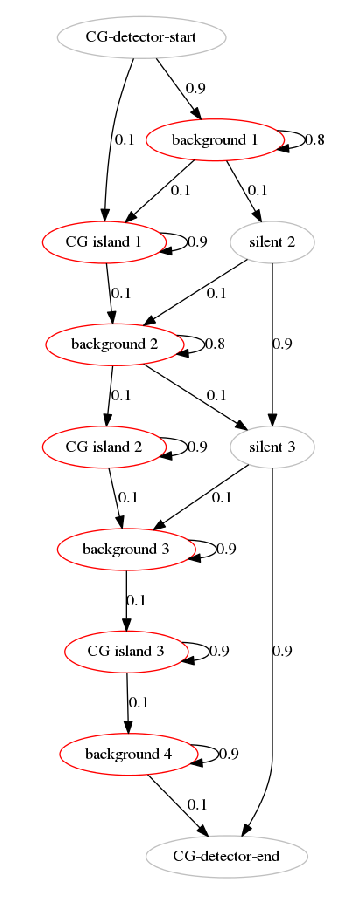

In [63]:
background = DiscreteDistribution({'A': 0.25, 'C': 0.25, 'G': 0.25, 'T': 0.25})
cg_island = DiscreteDistribution({'A': 0.10, 'C': 0.40, 'G': 0.40, 'T': 0.10})

s1 = State(background, name='background 1')
s2 = State(cg_island, name='CG island 1')
s3 = State(background, name='background 2')
s4 = State(cg_island, name='CG island 2')
s5 = State(background, name='background 3')
s6 = State(cg_island, name='CG island 3')
s7 = State(background, name='background 4')

s8 = State(None, 'silent 2')
s9 = State(None, 'silent 3')

model = HiddenMarkovModel("CG-detector")
model.add_states(s1, s2, s3, s4, s5, s6, s7, s8, s9)
model.add_transition(model.start, s1, 0.9)
model.add_transition(model.start, s2, 0.1)
model.add_transition(s1, s1, 0.80)
model.add_transition(s1, s2, 0.10)
model.add_transition(s2, s3, 0.10)
model.add_transition(s2, s2, 0.90)
model.add_transition(s3, s3, 0.80)
model.add_transition(s3, s4, 0.10)
model.add_transition(s4, s5, 0.10)
model.add_transition(s4, s4, 0.90)
model.add_transition(s5, s5, 0.90)
model.add_transition(s5, s6, 0.10)
model.add_transition(s6, s7, 0.10)
model.add_transition(s6, s6, 0.90)
model.add_transition(s7, s7, 0.90)
model.add_transition(s7, model.end, 0.10)
model.add_transition(s1, s8, 0.10)
model.add_transition(s8, s9, 0.90)
model.add_transition(s8, s3, 0.10)
model.add_transition(s3, s9, 0.10)
model.add_transition(s9, model.end, 0.90)
model.add_transition(s9, s5, 0.10)
model.bake()

plt.figure(figsize=(8, 16))
model.plot()
plt.show()

Using silent states, we can construct a type of silent 'highway' which sequences can align to in order to avoid aligning to CG islands if the data does not support them. You can see that these silent states allow you to skip either the first CG island, the second one, or all of them, only aligning to background sequence. Let's see this in practice when aligning to a sequence with no CG islands.

In [64]:
seq = list('ACGTACGTACGTACGTACGTACGTACGTACGTACGTACGTACGT')
mod_predictions = model.predict(seq)
hmm_predictions = hmm.predict(seq)

print "sequence: {}".format( ''.join( seq ) )
print "hmm pred: {}".format( ''.join( map( str, hmm_predictions ) ) )
print "3GC pred: {}".format( ''.join( map( str, mod_predictions ) ) )
print
print "Prior HMM Model\n", "\n".join( "{} : {}".format(state.name, i) for i, state in enumerate(hmm.states))
print
print "3GC Model\n", "\n".join( "{} : {}".format(state.name, i) for i, state in enumerate(model.states))

sequence: ACGTACGTACGTACGTACGTACGTACGTACGTACGTACGTACGT
hmm pred: 11111111111111111111111111111111111111111111
3GC pred: 33333333455555555555555555555566666666666666

Prior HMM Model
CG island : 0
background : 1
CG-detector-start : 2
CG-detector-end : 3

3GC Model
CG island 1 : 0
CG island 2 : 1
CG island 3 : 2
background 1 : 3
background 2 : 4
background 3 : 5
background 4 : 6
silent 2 : 7
silent 3 : 8
CG-detector-start : 9
CG-detector-end : 10


Since we are using maximum a posteriori estimates for `model.predict_proba`, we get a mesh of all possible background states for the states predicted for each observation. This is because the maximum a posteriori estimates use a sum of all possible paths, which sometimes yield more accurate results, and sometimes yield more interesting results. If instead we were to look at the Viterbi path, which is the single most probable path through the model, we would get a far more stable and expected path.

## 1. GMM-HMM

As was mentioned previously, hidden Markov models add a structural element to distributions, allowing them to analyze arbitrarily lengthed sequences of data. The most common uses of HMMs involve the use of discrete distributions, such as in bioinformatics, or Gaussian distributions. However, HMMs really can be done over arbitrary probabilistic models, as long as they allow for the calculation of log probabilites and weighted updates. An example of this is to create a HMM with GeneralMixtureModel emissions. In essence, each node has a mixture of distributions representing it, allowing it to capture a fuller representation of the underlying data.

Let's take a look at how easy this is in pomegranate.

In [65]:
X = [9.6, 9.9, 11.4, 15.2, 13.1, 10.4, 10.2, 9.8, 9.5, 8.2, 10.3, 14.2, 13.1]

d1 = GeneralMixtureModel([NormalDistribution(5, 2), NormalDistribution(5, 4)])
d2 = GeneralMixtureModel([NormalDistribution(15, 1), NormalDistribution(15, 5)])

s1 = State(d1, name="GMM1")
s2 = State(d2, name="GMM2")

model = HiddenMarkovModel()
model.add_states(s1, s2)
model.add_transition(model.start, s1, 0.75)
model.add_transition(model.start, s2, 0.25)
model.add_transition(s1, s1, 0.85)
model.add_transition(s1, s2, 0.15)
model.add_transition(s2, s2, 0.90)
model.add_transition(s2, s1, 0.10)
model.bake()

print model.predict_proba(X)

[[ 0.65227912  0.34772088]
 [ 0.41463699  0.58536301]
 [ 0.13268346  0.86731654]
 [ 0.00185018  0.99814982]
 [ 0.01294739  0.98705261]
 [ 0.13511722  0.86488278]
 [ 0.25952093  0.74047907]
 [ 0.37707309  0.62292691]
 [ 0.45202487  0.54797513]
 [ 0.46337568  0.53662432]
 [ 0.2282899   0.7717101 ]
 [ 0.0064963   0.9935037 ]
 [ 0.01230074  0.98769926]]


All we had to do is make the distribution be a GeneralMixtureModel instead of an object which ends in Distribution. Since this isn't a separate object, all of the same benefits that you get from a more typical HMM can be used here including multithreaded training, pseudocounts for training, silent states, etc... In fact, it's worth noting that not all states even have to be mixtures--since GeneralMixtureModels are still just a probability distribution, you can use them interchangably.

In [66]:
d1 = GeneralMixtureModel([NormalDistribution(5, 2), NormalDistribution(5, 4)])
d2 = NormalDistribution(15, 1)

s1 = State(d1, name="GMM1")
s2 = State(d2, name="Norm2")

model = HiddenMarkovModel()
model.add_states(s1, s2)
model.add_transition(model.start, s1, 0.75)
model.add_transition(model.start, s2, 0.25)
model.add_transition(s1, s1, 0.85)
model.add_transition(s1, s2, 0.15)
model.add_transition(s2, s2, 0.90)
model.add_transition(s2, s1, 0.10)
model.bake()

print model.predict_proba(X)

[[ 0.99999978  0.00000022]
 [ 0.99999798  0.00000202]
 [ 0.95807881  0.04192119]
 [ 0.0228916   0.9771084 ]
 [ 0.10180952  0.89819048]
 [ 0.99957345  0.00042655]
 [ 0.99999662  0.00000338]
 [ 0.99999963  0.00000037]
 [ 0.99999994  0.00000006]
 [ 1.          0.        ]
 [ 0.99972047  0.00027953]
 [ 0.01747232  0.98252768]
 [ 0.01685506  0.98314494]]


By adding in the second GMM, we were able to represent a spike in probability at 15, but also a wider base by mixing it with a distribution that had a large variance. Because of this, more of the symbols in X belonged to it than if we simply used a single distribution.

## 6. Bayesian Networks

Bayesian networks are a powerful inference tool, in which a set of variables are represented as nodes, and the lack of an edge represents a conditional independence statement between the two variables, and an edge represents a dependence between the two variables. One of the powerful components of a Bayesian network is the ability to infer the values of some variables given observed values for the remaining variables. These are referred to as the 'hidden' and 'observed' variables respectively, and need not be set at the time the network is created. The same network can have a different set of variables be hidden or observed between two data points. The more values which are observed, the closer the inferred values will be to the truth.

Bayesian networks typically are either over discrete observations (like True/False, A/B/C) or are linear-gaussian (where all observations are continuous and parents effect their children in a linear manner). pomegranate currently only supports discrete observations, but has plans to both support linear-gaussian models, and meshes of both discrete and linear-gaussian models.

Let's get down to a simple example from medical diagnosis. While not everyone can be as good at diagnosis as Dr. House, we can get pretty good with math. 

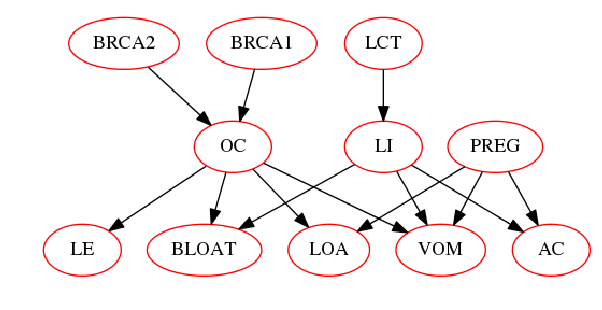

In [67]:
BRCA1 = DiscreteDistribution({0: 0.999, 1: 0.001})
BRCA2 = DiscreteDistribution({0: 0.985, 1: 0.015})
LCT   = DiscreteDistribution({0: 0.950, 1: 0.050})

OC = ConditionalProbabilityTable([[0, 0, 0, 0.999],
                                  [0, 0, 1, 0.001],
                                  [0, 1, 0, 0.750],
                                  [0, 1, 1, 0.250],
                                  [1, 0, 0, 0.700],
                                  [1, 0, 1, 0.300],
                                  [1, 1, 0, 0.050],
                                  [1, 1, 1, 0.950]], [BRCA1, BRCA2])

LI = ConditionalProbabilityTable([[0, 0, 0.99],
                                  [0, 1, 0.01],
                                  [1, 0, 0.20],
                                  [1, 1, 0.80]], [LCT])

PREG = DiscreteDistribution({0: 0.90, 1: 0.10})

LE = ConditionalProbabilityTable([[0, 0, 0.99],
                                  [0, 1, 0.01],
                                  [1, 0, 0.25],
                                  [1, 1, 0.75]], [OC])

BLOAT = ConditionalProbabilityTable([[0, 0, 0, 0.85],
                                     [0, 0, 1, 0.15],
                                     [0, 1, 0, 0.70],
                                     [0, 1, 1, 0.30],
                                     [1, 0, 0, 0.40],
                                     [1, 0, 1, 0.60],
                                     [1, 1, 0, 0.10],
                                     [1, 1, 1, 0.90]], [OC, LI])

LOA = ConditionalProbabilityTable([[0, 0, 0, 0.99],
                                   [0, 0, 1, 0.01],
                                   [0, 1, 0, 0.30],
                                   [0, 1, 1, 0.70],
                                   [1, 0, 0, 0.95],
                                   [1, 0, 1, 0.05],
                                   [1, 1, 0, 0.95],
                                   [1, 1, 1, 0.05]], [PREG, OC])

VOM = ConditionalProbabilityTable([[0, 0, 0, 0, 0.99],
                                   [0, 0, 0, 1, 0.01],
                                   [0, 0, 1, 0, 0.80],
                                   [0, 0, 1, 1, 0.20],
                                   [0, 1, 0, 0, 0.40],
                                   [0, 1, 0, 1, 0.60],
                                   [0, 1, 1, 0, 0.30],
                                   [0, 1, 1, 1, 0.70],
                                   [1, 0, 0, 0, 0.30],
                                   [1, 0, 0, 1, 0.70],
                                   [1, 0, 1, 0, 0.20],
                                   [1, 0, 1, 1, 0.80],
                                   [1, 1, 0, 0, 0.05],
                                   [1, 1, 0, 1, 0.95],
                                   [1, 1, 1, 0, 0.01],
                                   [1, 1, 1, 1, 0.99]], [PREG, OC, LI])

AC = ConditionalProbabilityTable([[0, 0, 0, 0.95],
                                  [0, 0, 1, 0.05],
                                  [0, 1, 0, 0.01],
                                  [0, 1, 1, 0.99],
                                  [1, 0, 0, 0.40],
                                  [1, 0, 1, 0.60],
                                  [1, 1, 0, 0.20],
                                  [1, 1, 1, 0.80]], [PREG, LI])

s1 = Node(BRCA1, name="BRCA1")
s2 = Node(BRCA2, name="BRCA2")
s3 = Node(LCT, name="LCT")
s4 = Node(OC, name="OC")
s5 = Node(LI, name="LI")
s6 = Node(PREG, name="PREG")
s7 = Node(LE, name="LE")
s8 = Node(BLOAT, name="BLOAT")
s9 = Node(LOA, name="LOA")
s10 = Node(VOM, name="VOM")
s11 = Node(AC, name="AC")

model = BayesianNetwork("Hut")
model.add_nodes(s1, s2, s3, s4, s5, s6, s7, s8, s9, s10, s11)
model.add_edge(s1, s4)
model.add_edge(s2, s4)
model.add_edge(s3, s5)
model.add_edge(s4, s7)
model.add_edge(s4, s8)
model.add_edge(s4, s9)
model.add_edge(s4, s10)
model.add_edge(s5, s8)
model.add_edge(s5, s10)
model.add_edge(s5, s11)
model.add_edge(s6, s9)
model.add_edge(s6, s10)
model.add_edge(s6, s11)
model.bake()
model.plot()
plt.show()

In [68]:
d = model.predict_proba()
print "\t".join( "{:7}".format(state.name) for state in model.states )
print "\t".join( "{:4.2}".format(model.parameters[0][1]) for model in d )

BRCA1  	BRCA2  	LCT    	OC     	LI     	PREG   	LE     	BLOAT  	LOA    	VOM    	AC     
0.001	0.015	0.05	0.005	0.05	 0.1	0.014	0.16	0.017	0.091	0.15


In [69]:
d = model.predict_proba({'BLOAT' : 1, 'LE' : 1, 'LOA' : 0, 'VOM' : 0, 'AC' : 0})
print "\t".join( "{:7}".format(state.name) for state in model.states )
print "\t".join( "{:4.2}".format(model.parameters[0][1]) for model in d )

BRCA1  	BRCA2  	LCT    	OC     	LI     	PREG   	LE     	BLOAT  	LOA    	VOM    	AC     
0.01	0.13	0.012	0.16	0.0015	0.017	 1.0	 1.0	 0.0	 0.0	 0.0


In [70]:
d = model.predict_proba({'BLOAT' : 1, 'LE' : 1, 'LOA' : 0, 'VOM' : 0, 'AC' : 0, 'BRCA1' : 0, 'BRCA2' : 1})
print "\t".join( "{:7}".format(state.name) for state in model.states )
print "\t".join( "{:4.2}".format(model.parameters[0][1]) for model in d )

BRCA1  	BRCA2  	LCT    	OC     	LI     	PREG   	LE     	BLOAT  	LOA    	VOM    	AC     
 0.0	 1.0	0.011	0.92	0.0012	0.02	 1.0	 1.0	 0.0	 0.0	 0.0


In [71]:
d = model.predict_proba({'VOM' : 1, 'BLOAT' : 1, 'LE' : 1})
print "\t".join( "{:7}".format(state.name) for state in model.states )
print "\t".join( "{:4.2}".format(model.parameters[0][1]) for model in d )

BRCA1  	BRCA2  	LCT    	OC     	LI     	PREG   	LE     	BLOAT  	LOA    	VOM    	AC     
0.056	0.68	0.087	0.91	0.096	 0.2	 1.0	 1.0	0.52	 1.0	0.24


In [72]:
d = model.predict_proba({'VOM' : 1, 'BLOAT' : 1, 'LE' : 1, 'LOA' : 1, 'VOM' : 1, 'AC' : 0})
print "\t".join( "{:7}".format(state.name) for state in model.states )
print "\t".join( "{:4.2}".format(model.parameters[0][1]) for model in d )

BRCA1  	BRCA2  	LCT    	OC     	LI     	PREG   	LE     	BLOAT  	LOA    	VOM    	AC     
0.061	0.75	0.011	 1.0	0.0012	0.0056	 1.0	 1.0	 1.0	 1.0	 0.0


In [73]:
d = model.predict_proba({'VOM' : 1, 'BLOAT' : 1, 'LE' : 1, 'LOA' : 0, 'VOM' : 1, 'AC' : 0})
print "\t".join( "{:7}".format(state.name) for state in model.states )
print "\t".join( "{:4.2}".format(model.parameters[0][1]) for model in d )

BRCA1  	BRCA2  	LCT    	OC     	LI     	PREG   	LE     	BLOAT  	LOA    	VOM    	AC     
0.05	 0.6	0.026	0.81	0.019	0.31	 1.0	 1.0	 0.0	 1.0	 0.0


# Parallelization

pomegranate has built in functions for parallelization. Ultimately all you need to do is wrap the calling of summarization with some sort of parallelization library. In this case I am using joblib, as it is easy to use and performs extremely well. It is also used as the backend for scikit-learn, which lends it credibility.

You can currently get parallelized versions of the following functions:

1. predict
2. predict_proba
3. predict_log_proba
4. summarize
5. fit

It's important to note that 'summarize' by itself does not completely fit unsupervised algorithms like HMM and GMMs, it has to be done iteratively. 'summarize' will simply calculate the suficient statistics for this particular dataset and store them in the model. However, 'fit' will perform a complete fit, and takes all the same arguments that 'model.fit' would take, specifically 'stop_threshold' and 'max_iterations'. You can specify which backend you would like for each of these functions, either 'multiprocessing' or 'threading', but 'threading' is the default for increased performance.

Let's start off with parallelizing the predictions from a GeneralMixtureModel. The same code should work for all models in pomegranate, with differing leveels of efficiency.

In [74]:
mus = numpy.random.normal(0, 10, (25, 5))
distributions = [MultivariateGaussianDistribution(mu, numpy.eye(5)) for mu in mus]
model = GeneralMixtureModel(distributions)
X = numpy.concatenate([numpy.random.normal(mu, 1.5, (100000, 5)) for mu in mus])

Let's see how long it takes to do predictions with the two methods. 

In [75]:
%timeit model.predict(X)
%timeit predict(model, X, n_jobs=1)
%timeit predict(model, X, n_jobs=4)

1 loop, best of 3: 3.54 s per loop
1 loop, best of 3: 3.49 s per loop
1 loop, best of 3: 1.11 s per loop


Now let's make sure that we are getting the same results for both of them.

In [76]:
print "Complete Match: ", (model.predict(X) == predict(model, X, n_jobs=4)).all()
print model.predict(X[:20])
print predict(model, X[:20], n_jobs=4)

Complete Match:  True
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


This can work just as easily with Naive Bayes as it would work with GMMs.

In [77]:
model = NaiveBayes(distributions)

In [78]:
%timeit model.predict_proba(X)
%timeit predict_proba(model, X, n_jobs=4)

1 loop, best of 3: 8.94 s per loop
1 loop, best of 3: 3.21 s per loop


We can also connfirm that this is producing the correct result.

In [79]:
(model.predict_proba(X[:100]) - predict_proba(model, X[:100], n_jobs=4)).sum()

0.0

## Fitting a Mixture of HMMs in Parallel

Finally, let's get to the grand finale. We'd like to fit a mixture of hidden Markov models in parallel. Let's take the example from my undergraduate research, in which we are sequencing a mixture of molecules which differ in a single position, and we'd like to be able to build a classifier to identify these modifications in future DNA molecules that we see. In this particular case, what we are looking at is the canonical nucleotide cytosine, a modified version called methylcytosine, and a different modified version called hydroxymethylcytosine. If our sequencing device can distinguish between these minor modifications in addition to the four canonical nucleotides, it would be a huge leap forward compared to traditonal sequencing devices.

The HMMs which we build will utilize the concepts which we've covered previously in the HMM section. Specifically, they will utilize silent states to allow for skips in the profile of arbitrary lengths without explicitly drawing all of the edges, and tied distributions ~across models~. Not only will multiple states in the same HMM have a tied distribution, but you can even tie these distributions across models in order to ensure that the models don't overfit to slight fluctuations in the background sequence. This distribution tying can be done in the same manner it was done before, just by passing in the same distribution object to states going into different HMMs.

Let's create two functions, one which will create a generla profile HMM if you pass it the list of matches, and a function which will build the mixture model using this function and some hand specified initial values.

In [80]:
def create_profile_hmm(distributions, insert):
    i0 = State(insert, name="i0")
   
    model = HiddenMarkovModel()
    model.add_state(i0)
    model.add_transition(model.start, i0, 0.10)
    model.add_transition(i0, i0, 0.30)
    
    last_insert = i0
    last_delete = None
    last_match = model.start
    
    for i in range(1, len(distributions)+1):
        ii = State(insert, name="i{}".format(i))
        di = State(None, name="d{}".format(i))
        mi = State(distributions[i-1], name="m{}".format(i))
        
        model.add_states(ii, di, mi)
        model.add_transition(last_insert, mi, 0.60)
        model.add_transition(last_insert, di, 0.10)
        model.add_transition(ii, ii, 0.30)
        
        model.add_transition(last_match, mi, 0.80)
        model.add_transition(last_match, di, 0.10)
        model.add_transition(mi, ii, 0.10)
        
        if i > 1:
            model.add_transition(last_delete, mi, 0.70)
            model.add_transition(last_delete, di, 0.30)
        
        last_insert, last_delete, last_match = ii, di, mi
        
    model.add_transition(di, model.end, 1.0)
    model.add_transition(ii, model.end, 0.7)
    model.add_transition(mi, model.end, 0.9)
    model.bake()
    return model

def create_mixture_model():
    mu_C = [NormalDistribution(mu, 1) for mu in 10, 12, 17, 18, 14, 20, 18, 6]
    mu_mC = [NormalDistribution(mu, 1) for mu in 11, 14, 19, 22, 15, 23, 19, 6]
    mu_hmC = [NormalDistribution(mu, 1) for mu in 10, 12, 14, 14, 12, 19, 14, 4]

    C = NormalDistribution(1, 1)
    A = NormalDistribution(5, 1)
    T = NormalDistribution(9, 1)
    I = NormalDistribution(0, 25)


    dC   = [C, A, T, C, A, T, C, A, T, C, A, T, C, A, T, C, A, T] + mu_C + [C, A, T, C, A, T, C, A, T, C, A, T]
    dmC  = [C, A, T, C, A, T, C, A, T, C, A, T, C, A, T, C, A, T] + mu_mC + [C, A, T, C, A, T, C, A, T, C, A, T]
    dhmC = [C, A, T, C, A, T, C, A, T, C, A, T, C, A, T, C, A, T] + mu_hmC + [C, A, T, C, A, T, C, A, T, C, A, T]

    model_C = create_profile_hmm(dC, I)
    model_mC = create_profile_hmm(dmC, I)
    model_hmC = create_profile_hmm(dhmC, I)

    model = GeneralMixtureModel([model_C, model_mC, model_hmC])
    return model

Let's take a quick look at what exactly we're producing here by creating a profile HMM which models two positions.

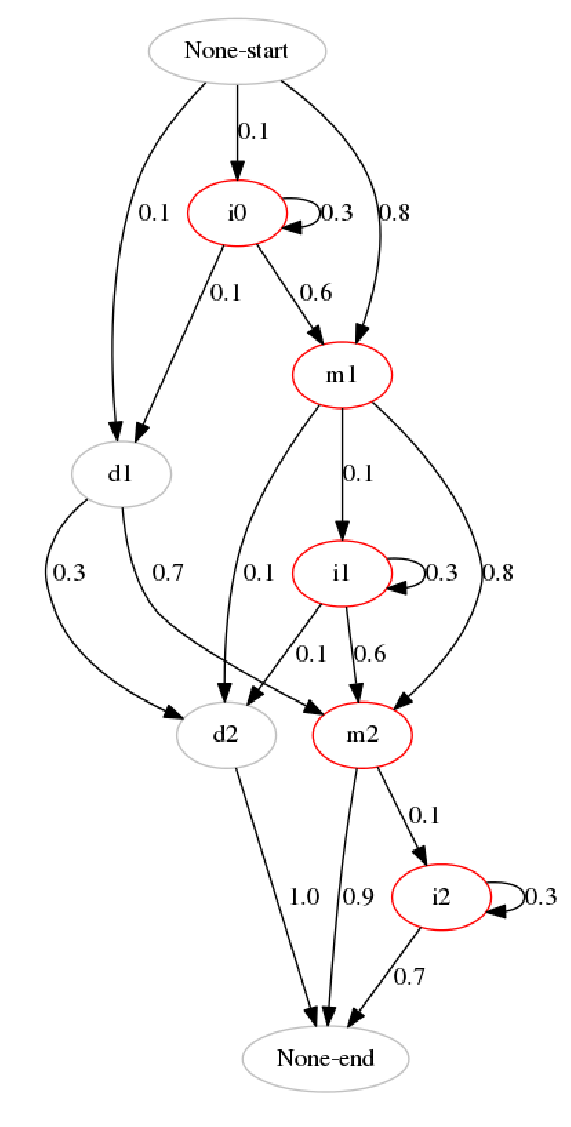

In [81]:
a = [NormalDistribution(5, 2), NormalDistribution(10, 1)]
model = create_profile_hmm(a, UniformDistribution(0, 10))

plt.figure(figsize=(20, 20))
model.plot()
plt.show()

In [82]:
model = create_mixture_model()
model.predict_proba([model.distributions[0].sample(), model.distributions[1].sample(), model.distributions[2].sample()])

array([[ 0.06358343,  0.93639787,  0.00001869],
       [ 0.00002803,  0.99997194,  0.00000003],
       [ 0.002274  ,  0.00004195,  0.99768405]])

Looks good so far. The mixture can identify that sequences generated from each of the components match those components well. 

Let's try to get a scale for how many distributions (in the form of states) and transition probabilities we are going to be training here.

In [83]:
model.distributions[0].edge_count(), model.distributions[1].state_count()

(307, 117)

Looks like we're going to be training 38 states with emissions and 307 edges, for around 383 parameters per model. Since we're going to be training three models, we're ultimately training over a thousand parameters in an unsupervised manner using Baum-Welch. 

Unfortunately getting the data ready in this format would be more difficult than necessary for this example. Let's instead draw 1000 samples from the model and use those as training samples. 

In [84]:
model = create_mixture_model()
X = [model.sample() for i in range(1000)]

tic = time.time()
fit(model, X, verbose=True, stop_threshold=1)
print "Time: {}s".format(time.time() - tic)
print

model = create_mixture_model()
tic = time.time()
fit(model, X, n_jobs=4, verbose=True, stop_threshold=1)
print "Time: {}s".format(time.time() - tic)

Improvement: 258.545879097
Improvement: 32.5015215128
Improvement: 9.40591073866
Improvement: 4.01438881751
Improvement: 2.0999120124
Improvement: 1.23961900354
Improvement: 0.795902410333
Total Improvement: 308.603133593
Time: 54.793806076s

Improvement: 258.545879097
Improvement: 32.5015215127
Improvement: 9.4059107385
Improvement: 4.01438881768
Improvement: 2.09991201243
Improvement: 1.23961900343
Improvement: 0.795902410435
Total Improvement: 308.603133593
Time: 16.447385788s


The more data we have and the bigger the model, the bigger the gain that we get from parallelization. This is because there is some overhead which requires the global interpreter lock, but the complexity of the underlying complexity grows at a rate faster than this overhead and does not require the GIL. This makes sense anyway, if you're finishing your fitting in a few seconds you likely don't need parallelization as much as if it is taking hours to fit your model properly.

## Final Remarks

Thank you for working through this tutorial of the basic functionality of the pomegranate package. I hope that you end up finding it relevant and useful for your work. If you have any exciting use cases I'd love to hear about how pomegranate was able to help you.

pomegranate is a work in progress, and unfortunately is not how I am able to spend the majority of my time. If you notice a bug or inconsistency, please open an issue on github. I try to respond to fix the bugs as soon as possible!